## CELDA 1: Imports y Funciones Base

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution, least_squares, minimize
import matplotlib.pyplot as plt
import warnings
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')

print("=" * 70)
print("SIR EPIDEMIC MODEL - FAIRFAX COUNTY, VIRGINIA")
print("STAT 4734 - Statistical Methods for Digital Twins")
print("=" * 70)

def sir_model(t, y, beta, gamma, N):
    """SIR model differential equations"""
    S, I, R = y
    dS = -beta * S * I / N
    dI = (beta * S * I / N) - (gamma * I)
    dR = gamma * I
    return [dS, dI, dR]

def sir_euler(S0, I0, R0, beta, gamma, N, dt=0.1, days=200):
    """Solve SIR model using Euler's method"""
    n_steps = int(days / dt)
    t = np.linspace(0, days, n_steps + 1)
    S = np.zeros(n_steps + 1)
    I = np.zeros(n_steps + 1)
    R = np.zeros(n_steps + 1)
    
    S[0], I[0], R[0] = S0, I0, R0
    
    for i in range(n_steps):
        dS = -beta * S[i] * I[i] / N
        dI = (beta * S[i] * I[i] / N) - gamma * I[i]
        dR = gamma * I[i]
        
        S[i+1] = max(0, S[i] + dt * dS)
        I[i+1] = max(0, I[i] + dt * dI)
        R[i+1] = max(0, R[i] + dt * dR)
    
    return t, S, I, R

def sir_runge_kutta(S0, I0, R0, beta, gamma, N, days=200):
    """Solve SIR model using scipy's solve_ivp (RK45)"""
    def sir_derivatives(t, y):
        S, I, R = y
        dS = -beta * S * I / N
        dI = beta * S * I / N - gamma * I
        dR = gamma * I
        return [dS, dI, dR]
    
    sol = solve_ivp(
        sir_derivatives,
        t_span=(0, days),
        y0=[S0, I0, R0],
        method='RK45',
        dense_output=True,
        max_step=1.0
    )
    
    t = np.linspace(0, days, int(days) + 1)
    y = sol.sol(t)
    
    return t, y[0], y[1], y[2]

def sir_cumulative_cases(params, time_points, population):
    """Simulate SIR model and return cumulative cases (R compartment)"""
    beta, gamma, I0 = params
    S0 = population - I0
    R0 = 0
    
    max_days = int(np.max(time_points)) + 1
    t, S, I, R = sir_runge_kutta(S0, I0, R0, beta, gamma, population, days=max_days)
    
    cumulative = np.array([R[int(t)] for t in time_points])
    return cumulative

def residuals_cumulative(params, time_points, observed, population):
    """Calculate residuals between model and observed cumulative cases"""
    if params[0] <= 0 or params[1] <= 0 or params[2] <= 0:
        return np.ones_like(observed) * 1e10
    
    try:
        predicted = sir_cumulative_cases(params, time_points, population)
        return predicted - observed
    except:
        return np.ones_like(observed) * 1e10

print("\n✓ Functions loaded successfully")

SIR EPIDEMIC MODEL - FAIRFAX COUNTY, VIRGINIA
STAT 4734 - Statistical Methods for Digital Twins

✓ Functions loaded successfully


In [2]:
# =============================================================================
# GLOBAL CONFIGURATION - MODIFY THESE SETTINGS AS NEEDED
# =============================================================================

# PARAMETER ESTIMATION OPTIONS
USE_ESTIMATED_PARAMETERS = True   # Set to False to use WHO or custom parameters
USE_WHO_PARAMETERS = False        # Set to True to use WHO-defined parameters (only if USE_ESTIMATED_PARAMETERS = False)

# WHO PARAMETERS (used if USE_WHO_PARAMETERS = True)
WHO_R0 = 2.2
WHO_GAMMA = 1/14
WHO_BETA = WHO_R0 * WHO_GAMMA

# CUSTOM PARAMETERS (used if both flags above are False)
# This is just an example; modify this to check different scenarios
CUSTOM_BETA = 0.3
CUSTOM_GAMMA = 0.1
CUSTOM_I0 = 1

# POPULATION FOR SAMPLE SCENARIOS
SAMPLE_POPULATION = 1000

# TRAIN/TEST SPLIT RATIO
TRAIN_RATIO = 0.75

# FORECAST HORIZONS
FORECAST_DAYS_14 = 14
FORECAST_DAYS_30 = 30

print("=" * 70)
print("CONFIGURATION SETTINGS")
print("=" * 70)
print(f"Parameter Estimation Mode:")
print(f"  ESTIMATES_PARAMETERS ?: {USE_ESTIMATED_PARAMETERS}")
print(f"  USE_WHO_PARAMETERS ?:       {USE_WHO_PARAMETERS}")
if USE_WHO_PARAMETERS: # Print WHO parameters
    print(f"\nWHO Parameters:")
    print(f"  R0:    {WHO_R0}")
    print(f"  β:     {WHO_BETA:.4f}")
    print(f"  γ:     {WHO_GAMMA:.4f}")
elif not USE_ESTIMATED_PARAMETERS: # Print custom parameters
    print(f"\nCustom Parameters:")
    print(f"  β:     {CUSTOM_BETA}")
    print(f"  γ:     {CUSTOM_GAMMA}")
    print(f"  I0:    {CUSTOM_I0}")
# We dont print any parameters if USE_ESTIMATED_PARAMETERS is True since 
# they will be estimated later from data



print(f"\nTrain/Test Split: {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")
print(f"Forecast Horizons: {FORECAST_DAYS_14} days, {FORECAST_DAYS_30} days")
print("=" * 70)

CONFIGURATION SETTINGS
Parameter Estimation Mode:
  ESTIMATES_PARAMETERS ?: True
  USE_WHO_PARAMETERS ?:       False

Train/Test Split: 75% / 25%
Forecast Horizons: 14 days, 30 days



TEST 1: EPIDEMIC SCENARIOS WITH VARYING R0


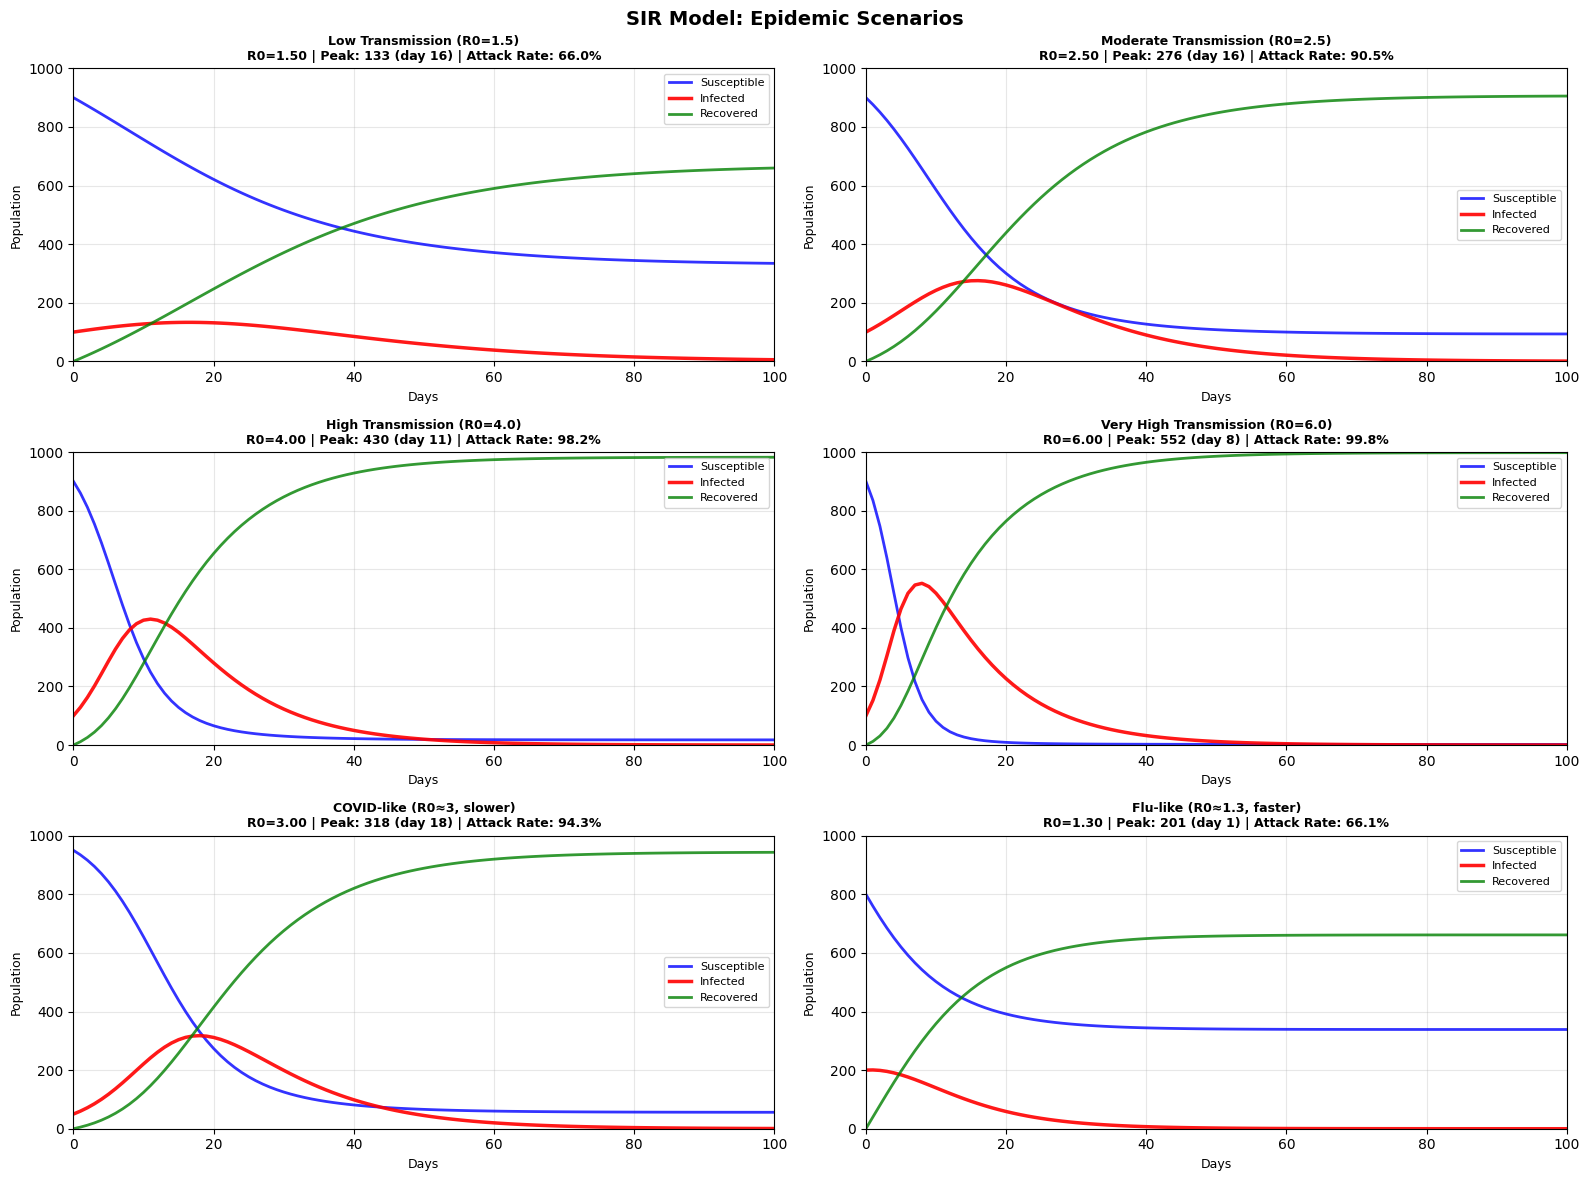


Scenario Summary:
1. Low Transmission (R0=1.5): R0=1.50
2. Moderate Transmission (R0=2.5): R0=2.50
3. High Transmission (R0=4.0): R0=4.00
4. Very High Transmission (R0=6.0): R0=6.00
5. COVID-like (R0≈3, slower): R0=3.00
6. Flu-like (R0≈1.3, faster): R0=1.30

TEST 2: EXTREME EDGE CASES


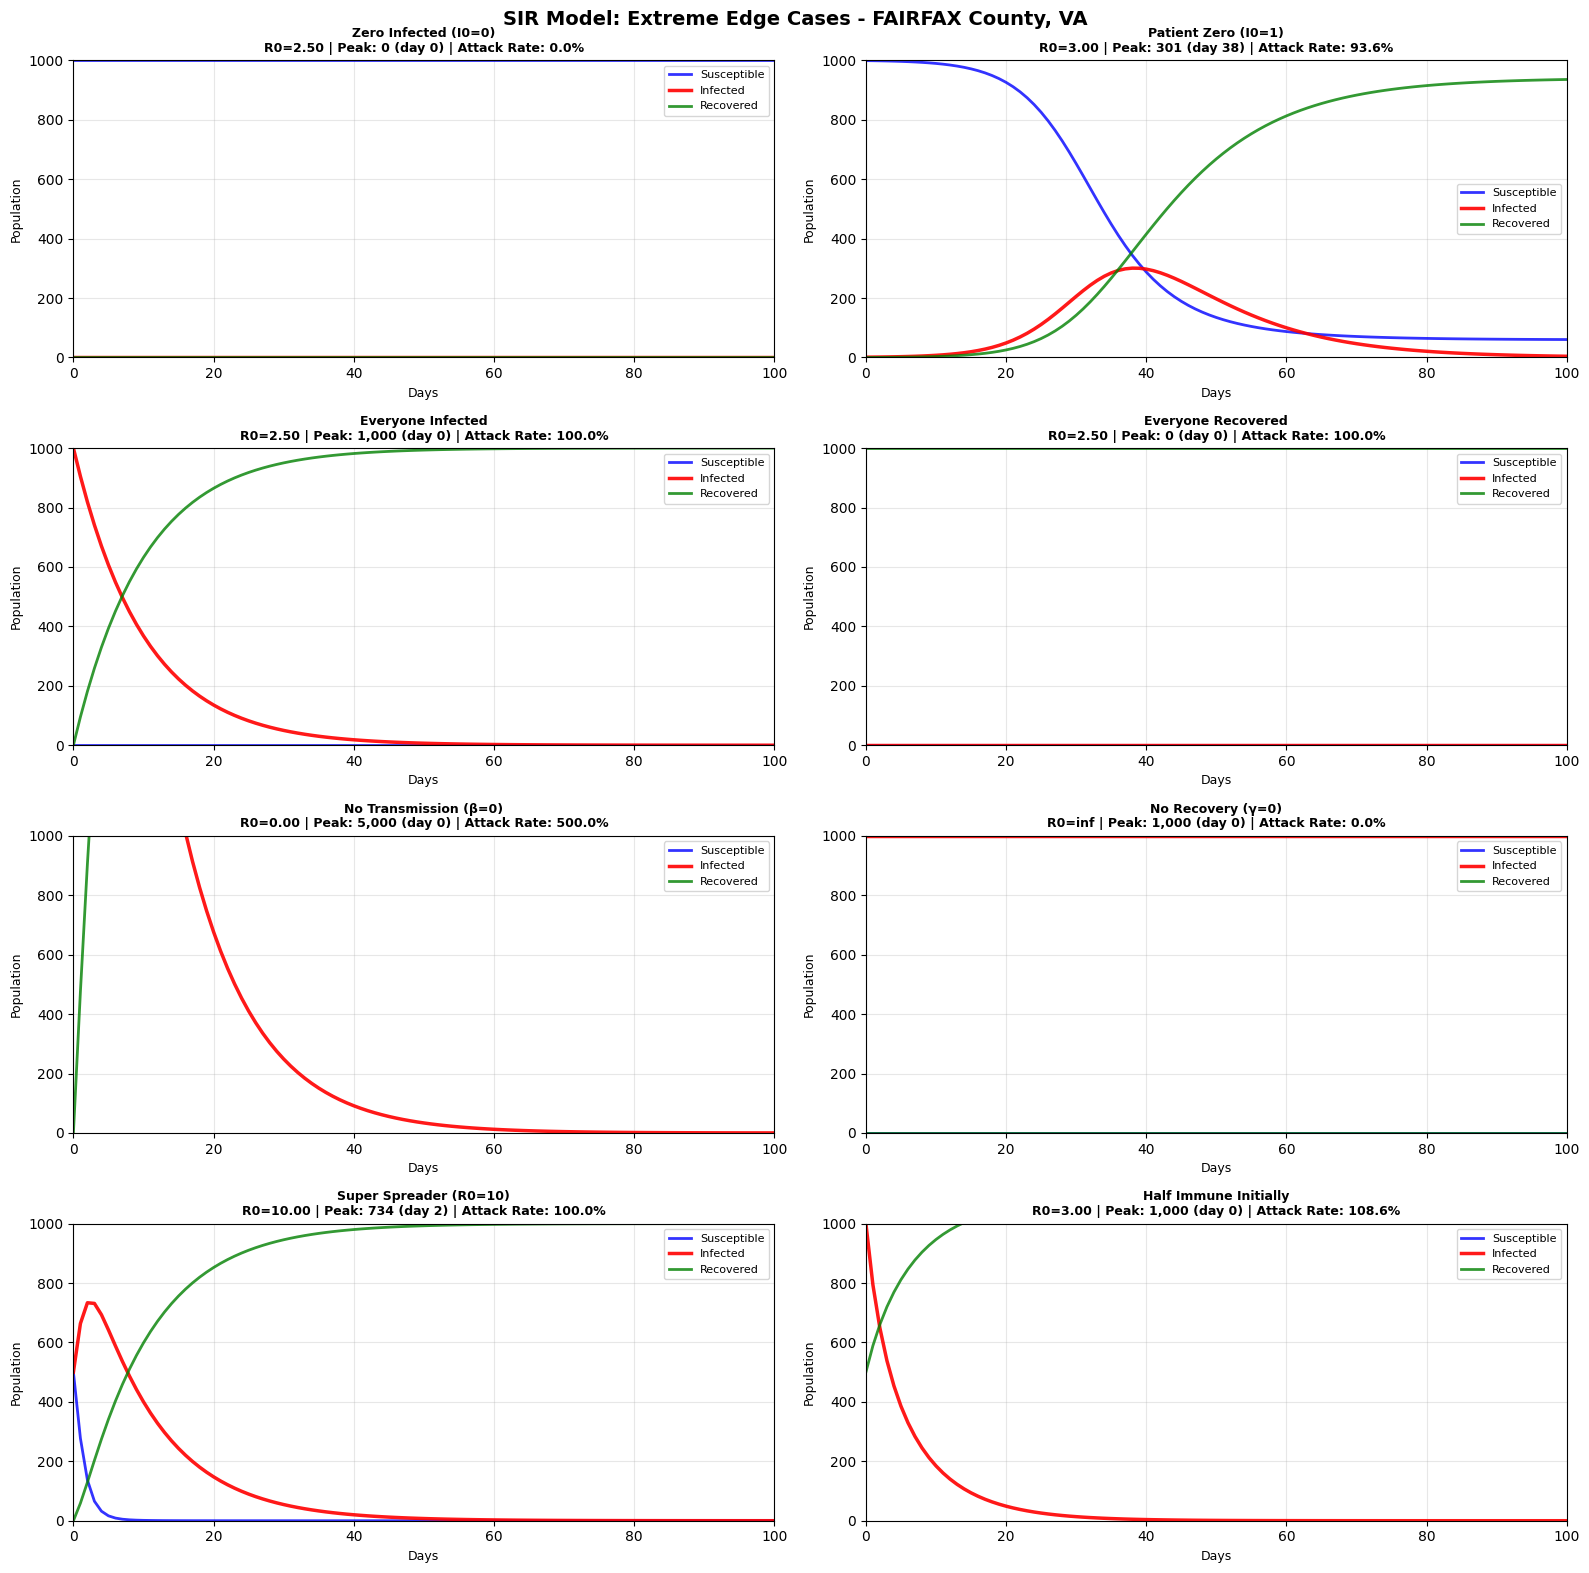


Scenario Summary:
1. Zero Infected (I0=0): R0=2.50
2. Patient Zero (I0=1): R0=3.00
3. Everyone Infected: R0=2.50
4. Everyone Recovered: R0=2.50
5. No Transmission (β=0): R0=0.00
6. No Recovery (γ=0): R0=inf
7. Super Spreader (R0=10): R0=10.00
8. Half Immune Initially: R0=3.00


In [3]:
print("\n" + "=" * 70)
print("TEST 1: EPIDEMIC SCENARIOS WITH VARYING R0")
print("=" * 70)

scenarios = [
    {"name": "Low Transmission (R0=1.5)", "beta": 0.15, "gamma": 0.10, "I0": 100},
    {"name": "Moderate Transmission (R0=2.5)", "beta": 0.25, "gamma": 0.10, "I0": 100},
    {"name": "High Transmission (R0=4.0)", "beta": 0.40, "gamma": 0.10, "I0": 100},
    {"name": "Very High Transmission (R0=6.0)", "beta": 0.60, "gamma": 0.10, "I0": 100},
    {"name": "COVID-like (R0≈3, slower)", "beta": 0.30, "gamma": 0.10, "I0": 50},
    {"name": "Flu-like (R0≈1.3, faster)", "beta": 0.26, "gamma": 0.20, "I0": 200}
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    I0 = scenario["I0"]
    S0 = SAMPLE_POPULATION - scenario["I0"]
    R0 = 0
    days = 100
    
    t, S, I, R = sir_runge_kutta(S0, I0, R0, 
                           scenario["beta"], scenario["gamma"], 
                           SAMPLE_POPULATION, days=days)
    
    ax = axes[idx]
    ax.plot(t, S, 'b-', label='Susceptible', linewidth=2, alpha=0.8)
    ax.plot(t, I, 'r-', label='Infected', linewidth=2.5, alpha=0.9)
    ax.plot(t, R, 'g-', label='Recovered', linewidth=2, alpha=0.8)
    
    R0_value = scenario["beta"] / scenario["gamma"]
    peak_infected = np.max(I)
    peak_day = t[np.argmax(I)]
    attack_rate = R[-1] / SAMPLE_POPULATION * 100
    
    ax.set_title(f'{scenario["name"]}\n' + 
                 f'R0={R0_value:.2f} | Peak: {peak_infected:,.0f} (day {peak_day:.0f}) | ' +
                 f'Attack Rate: {attack_rate:.1f}%', 
                 fontsize=9, fontweight='bold')
    ax.set_xlabel('Days', fontsize=9)
    ax.set_ylabel('Population', fontsize=9)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, days])
    ax.set_ylim([0, SAMPLE_POPULATION])

plt.suptitle('SIR Model: Epidemic Scenarios', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('material/plots/0_sir_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nScenario Summary:")
for idx, scenario in enumerate(scenarios):
    R0_value = scenario["beta"] / scenario["gamma"]
    print(f"{idx+1}. {scenario['name']}: R0={R0_value:.2f}")
    
    
print("\n" + "=" * 70)
print("TEST 2: EXTREME EDGE CASES")
print("=" * 70)

extreme_scenarios = [
    {"name": "Zero Infected (I0=0)", "beta": 0.25, "gamma": 0.1, "I0": 0, "R0": 0},
    {"name": "Patient Zero (I0=1)", "beta": 0.30, "gamma": 0.1, "I0": 1, "R0": 0},
    {"name": "Everyone Infected", "beta": 0.25, "gamma": 0.1, "I0": SAMPLE_POPULATION, "R0": 0},
    {"name": "Everyone Recovered", "beta": 0.25, "gamma": 0.1, "I0": 0, "R0": SAMPLE_POPULATION},
    {"name": "No Transmission (β=0)", "beta": 0.0, "gamma": 0.1, "I0": 5000, "R0": 0},
    {"name": "No Recovery (γ=0)", "beta": 0.25, "gamma": 0.0, "I0": 1000, "R0": 0},
    {"name": "Super Spreader (R0=10)", "beta": 1.0, "gamma": 0.1, "I0": 500, "R0": 0},
    {"name": "Half Immune Initially", "beta": 0.30, "gamma": 0.1, "I0": 1000, "R0": SAMPLE_POPULATION//2}
]

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, scenario in enumerate(extreme_scenarios):
    I0 = scenario["I0"]
    R0 = scenario["R0"]
    S0 = SAMPLE_POPULATION - I0 - R0
    days = 100
    
    
    t, S, I, R = sir_runge_kutta(S0, I0, R0, 
                           scenario["beta"], scenario["gamma"], 
                           SAMPLE_POPULATION, days=days)
    
    ax = axes[idx]
    ax.plot(t, S, 'b-', label='Susceptible', linewidth=2, alpha=0.8)
    ax.plot(t, I, 'r-', label='Infected', linewidth=2.5, alpha=0.9)
    ax.plot(t, R, 'g-', label='Recovered', linewidth=2, alpha=0.8)
    
    # Calculate statistics
    R0_value = (scenario["beta"] / scenario["gamma"]) if scenario["gamma"] > 0 else float('inf')
    peak_infected = np.max(I)
    peak_day = t[np.argmax(I)]
    attack_rate = R[-1] / SAMPLE_POPULATION * 100
    
    ax.set_title(f'{scenario["name"]}\n' + 
                 f'R0={R0_value:.2f} | Peak: {peak_infected:,.0f} (day {peak_day:.0f}) | ' +
                 f'Attack Rate: {attack_rate:.1f}%', 
                 fontsize=9, fontweight='bold')
    ax.set_xlabel('Days', fontsize=9)
    ax.set_ylabel('Population', fontsize=9)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, days])
    ax.set_ylim([0, SAMPLE_POPULATION])
    
    
plt.suptitle('SIR Model: Extreme Edge Cases - FAIRFAX County, VA', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('material/plots/1_sir_imaginary_edge_cases.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nScenario Summary:")
for idx, scenario in enumerate(extreme_scenarios):
    R0_value = scenario["beta"] / scenario["gamma"] if scenario["gamma"] > 0 else float('inf')
    print(f"{idx+1}. {scenario['name']}: R0={R0_value:.2f}")

In [4]:
print("\n" + "=" * 70)
print("LOADING FAIRFAX COUNTY COVID-19 DATA")
print("=" * 70)

# Load data
deaths_df = pd.read_csv('material/US_covid19_deaths.csv')
confirmed_df = pd.read_csv('material/US_covid19_confirmed.csv')

# Extract FAIRFAX County data
county_deaths = deaths_df[
    (deaths_df['Admin2'] == 'Fairfax') & 
    (deaths_df['Province_State'] == 'Virginia')
]
county_confirmed = confirmed_df[
    (confirmed_df['Admin2'] == 'Fairfax') & 
    (confirmed_df['Province_State'] == 'Virginia')
]

if county_deaths.empty or county_confirmed.empty:
    raise ValueError("Error: Could not find FAIRFAX County data")

# Get population
COUNTY_POPULATION = int(county_deaths['Population'].iloc[0])

# Get date columns and extract time series
date_columns = [col for col in confirmed_df.columns if '/' in col]
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

deaths_series = county_deaths[date_columns].values[0]
confirmed_series = county_confirmed[date_columns].values[0]

# Create base DataFrame
county_data = pd.DataFrame({
    'date': dates,
    'cumulative_cases': confirmed_series,
    'cumulative_deaths': deaths_series,
})

# Make deaths monotonically increasing
shifts = (county_data['cumulative_deaths'].diff() < 0).astype(int) * county_data['cumulative_deaths'].diff().abs()
cumulative_shift = shifts.cumsum()
county_data['cumulative_deaths'] = county_data['cumulative_deaths'] + cumulative_shift

# Calculate daily new cases and deaths
county_data['daily_cases'] = county_data['cumulative_cases'].diff().fillna(0)
county_data['daily_deaths'] = county_data['cumulative_deaths'].diff().fillna(0)

# Ensure non-negative daily values
county_data['daily_cases'] = county_data['daily_cases'].clip(lower=0)
county_data['daily_deaths'] = county_data['daily_deaths'].clip(lower=0)

# Filter to start from first positive case

# This is important to avoid initial zero-case days so that we can ensure
# proper parameter estimation later on

first_case_idx = (county_data['cumulative_cases'] > 0).idxmax()
county_data = county_data.loc[first_case_idx:].reset_index(drop=True)

print(f"\nData loaded successfully:")
print(f"County: FAIRFAX County, Virginia")
print(f"Population: {COUNTY_POPULATION:,}")
print(f"First positive case date: {county_data['date'].iloc[0].strftime('%Y-%m-%d')}")
print(f"Date range: {county_data['date'].min()} to {county_data['date'].max()}")
print(f"Total days: {len(county_data)}")
print(f"Total cumulative cases: {county_data['cumulative_cases'].iloc[-1]:,.0f}")
print(f"Total cumulative deaths: {county_data['cumulative_deaths'].iloc[-1]:,.0f}")


LOADING FAIRFAX COUNTY COVID-19 DATA

Data loaded successfully:
County: FAIRFAX County, Virginia
Population: 1,147,532
First positive case date: 2020-03-08
Date range: 2020-03-08 00:00:00 to 2022-12-11 00:00:00
Total days: 1009
Total cumulative cases: 246,667
Total cumulative deaths: 1,710


In [5]:
print("\n" + "=" * 70)
print("PARAMETER ESTIMATION / ASSIGNMENT")
print("=" * 70)

# Prepare observed data
cumulative_cases_observed = county_data['cumulative_cases'].values
n_days = len(cumulative_cases_observed)
time_points = np.arange(n_days)

if USE_ESTIMATED_PARAMETERS:
    print("\nMode: ESTIMATING parameters from data using Least Squares WITH NO BOUNDS")
    print("Run this cell to see that the estimation works without bounds, but it is ")
    print("not recommended epidemiologically.")
    print("In my case it gave an unrealistic Infectious period (1/γ):   71.83 days!")
    print("Check the results below.")
    print("=" * 70)
    
    best_result = None
    best_sse = np.inf
    
    # PARAMETER BOUNDS BASED ON COVID-19 EPIDEMIOLOGY
    # Lower bounds:
    # - β ≥ 0.05: Ensures R0 ≥ 0.5 (below 1 means sub-epidemic, but we allow it for declining phases)
    # - γ ≥ 0.05: Maximum infectious period of 20 days (γ = 1/infectious_period)
    # - I0 ≥ 1: At least one initial infected person
    bounds_lower = [0.05, 0.05, 1]
    
    # Upper bounds:
    # - β ≤ 3.0: Allows R0 up to ~30 (covers highly contagious variants)
    # - γ ≤ 0.5: Minimum infectious period of 2 days (unrealistic to recover faster)
    # - I0 ≤ 10000: Upper limit for initial infected (can be adjusted based on county size)
    bounds_upper = [3.0, 0.5, 10000]
    
    # INITIAL GUESSES STRATEGY
    # We use multiple starting points because the optimization problem is non-convex
    # and can have multiple local minima. Each guess represents different epidemic scenarios:
    initial_guesses = [
        # [β, γ, I0] format
        # Scenario 1: Moderate spread, standard recovery (R0≈3.0)
        [0.3, 0.1, 10],    # 10-day infectious period, R0=3.0
        
        # Scenario 2: Higher transmission, faster recovery (R0≈3.3)
        [0.5, 0.15, 50],   # 6.7-day infectious period, R0=3.3
        
        # Scenario 3: Lower transmission, slower recovery (R0≈4.0)
        [0.2, 0.05, 100],  # 20-day infectious period, R0=4.0
        
        # Scenario 4: High transmission, rapid recovery (R0≈2.0)
        [0.4, 0.2, 5],     # 5-day infectious period, R0=2.0
        
        # Scenario 5: Low transmission, medium recovery (R0≈1.5)
        [0.15, 0.1, 200],  # 10-day infectious period, R0=1.5
        
        # Scenario 6: Very high transmission (R0≈4.0)
        [0.6, 0.15, 20],   # 6.7-day infectious period, R0=4.0
        
        # Scenario 7: Balanced parameters (R0≈3.1)
        [0.25, 0.08, 150], # 12.5-day infectious period, R0=3.1
        
        # Scenario 8: Moderate-high transmission (R0≈2.9)
        [0.35, 0.12, 75],  # 8.3-day infectious period, R0=2.9
        
        # Additional informed guesses based on COVID-19 literature
        # WHO estimates: R0=2-3, infectious period=7-10 days
        [0.3, 0.14, 30],   # 7-day period, R0=2.14 (WHO-like)
        [0.4, 0.1, 40],    # 10-day period, R0=4.0 (Delta-like)
        [0.5, 0.1, 25],    # 10-day period, R0=5.0 (Omicron-like)
    ]
    
    print(f"\nTrying {len(initial_guesses)} different initial guesses...")
    print(f"{'Run':<6} {'β':>10} {'γ':>10} {'R0':>8} {'I0':>8} {'SSE':>15} {'Success':<10}")
    print("-" * 70)
    
    for idx, guess in enumerate(initial_guesses):
        try:
            # OPTIMIZATION CONFIGURATION EXPLANATION:
            result = least_squares(
                residuals_cumulative,
                guess,
                args=(time_points, cumulative_cases_observed, COUNTY_POPULATION),
                #bounds=(bounds_lower, bounds_upper),
                
                # METHOD CHOICE: 'trf' (Trust Region Reflective)
                # - Best for bounded problems (we have parameter constraints)
                # - Robust to ill-conditioned problems
                # - Handles sparse Jacobians efficiently
                # Alternative: 'dogbox' for small problems, 'lm' for unconstrained
                method='lm',
                
                # TOLERANCE SETTINGS:
                # ftol: Function tolerance - stop when cost function changes less than this
                # xtol: Parameter tolerance - stop when parameters change less than this
                # Using 1e-6 instead of 1e-8 for faster convergence while maintaining accuracy
                ftol=1e-6,  # Relaxed from 1e-8 for practical convergence
                xtol=1e-6,  # Relaxed from 1e-8 for practical convergence
                
                # Maximum function evaluations
                # 5000 is generous for 3 parameters, ensures convergence even from poor starts
                max_nfev=5000,
                
                verbose=0  # Set to 1 or 2 for debugging
            )
            
            # SSE calculation: result.cost is 0.5 * sum(residuals^2), so multiply by 2
            sse = result.cost * 2
            beta, gamma, I0 = result.x
            R0 = beta / gamma
            
            print(f"{idx+1:<6} {beta:>10.4f} {gamma:>10.4f} {R0:>8.2f} {int(I0):>8} {sse:>15,.0f} {'✓' if result.success else '✗':<10}")
            
            # Keep track of best result based on SSE (Sum of Squared Errors)
            # Only consider successful optimizations to avoid spurious solutions
            if sse < best_sse and result.success:
                best_sse = sse
                best_result = result
                
        except Exception as e:
            # Handle any numerical issues or convergence failures gracefully
            print(f"{idx+1:<6} {'---':>10} {'---':>10} {'---':>8} {'---':>8} {'FAILED':>15} {'✗':<10}")
            # Optionally log the error for debugging:
            # print(f"  Error: {str(e)[:50]}")
    
    if best_result is None:
        raise ValueError("Error: No successful optimization found! Consider:\n"
                        "  1. Relaxing parameter bounds\n"
                        "  2. Adding more diverse initial guesses\n"
                        "  3. Checking data quality\n"
                        "  4. Increasing max_nfev or relaxing tolerances")
    
    BETA_GLOBAL, GAMMA_GLOBAL, I0_GLOBAL = best_result.x
    
    print("\n" + "-" * 70)
    print("ESTIMATION RESULTS")
    print("-" * 70)

elif USE_WHO_PARAMETERS:
    print("\nMode: USING WHO-defined parameters")
    print("=" * 70)
    
    BETA_GLOBAL = WHO_BETA
    GAMMA_GLOBAL = WHO_GAMMA
    
    # When using WHO parameters, we only estimate I0 (initial infected)
    # This is a 1D optimization problem, much simpler than the full 3-parameter problem
    def objective_I0_only(I0, time_points, observed, beta, gamma, population):
        """
        Objective function for estimating only I0 with fixed β and γ.
        Returns sum of squared errors between predicted and observed cumulative cases.
        """
        # Ensure I0 is positive (epidemiologically meaningful)
        if I0[0] <= 0:
            return 1e10  # Large penalty for invalid values
        try:
            predicted = sir_cumulative_cases([beta, gamma, I0[0]], time_points, population)
            residuals = predicted - observed
            return np.sum(residuals**2)
        except:
            # Return large penalty if model fails (numerical issues)
            return 1e10
    
    # Using L-BFGS-B for 1D bounded optimization
    # It's more efficient than least_squares for scalar problems
    result_I0 = minimize(
        objective_I0_only,
        x0=[10],  # Conservative initial guess
        args=(time_points, cumulative_cases_observed, BETA_GLOBAL, GAMMA_GLOBAL, COUNTY_POPULATION),
        bounds=[(1, 5000)],  # Allow wide range for I0
        method='L-BFGS-B'  # Efficient for low-dimensional bounded problems
    )
    
    I0_GLOBAL = result_I0.x[0]
    
    print(f"\nWHO Parameters (Fixed):")
    print(f"  R0 = {WHO_R0:.2f}")
    print(f"  β  = {BETA_GLOBAL:.6f} per day")
    print(f"  γ  = {GAMMA_GLOBAL:.6f} per day")
    print(f"\nEstimated from data:")
    print(f"  I0 = {int(I0_GLOBAL)} persons")
    
else:
    print("\nMode: USING CUSTOM parameters")
    print("=" * 70)
    
    BETA_GLOBAL = CUSTOM_BETA
    GAMMA_GLOBAL = CUSTOM_GAMMA
    I0_GLOBAL = CUSTOM_I0
    
    print(f"\nCustom Parameters:")

# Calculate derived parameters for interpretation
R0_GLOBAL = BETA_GLOBAL / GAMMA_GLOBAL  # Basic reproduction number
INFECTIOUS_PERIOD_GLOBAL = 1 / GAMMA_GLOBAL  # Average days infectious

# Display final parameters with epidemiological interpretation
print(f"β (Transmission rate):     {BETA_GLOBAL:.6f} per day")
print(f"γ (Recovery rate):         {GAMMA_GLOBAL:.6f} per day")
print(f"R0 (Basic reproduction):   {R0_GLOBAL:.4f}")
print(f"Infectious period (1/γ):   {INFECTIOUS_PERIOD_GLOBAL:.2f} days")
print(f"Initial infected (I0):     {int(I0_GLOBAL)} persons")

if USE_ESTIMATED_PARAMETERS:
    print(f"Sum of Squared Errors:     {best_sse:,.2f}")
    
    # Optional: Add goodness-of-fit metrics
    # Calculate R-squared for model evaluation
    ss_tot = np.sum((cumulative_cases_observed - np.mean(cumulative_cases_observed))**2)
    r_squared = 1 - (best_sse / ss_tot) if ss_tot > 0 else 0
    print(f"R-squared:                 {r_squared:.4f}")
    
    # Calculate RMSE (Root Mean Square Error)
    rmse = np.sqrt(best_sse / n_days)
    print(f"RMSE:                      {rmse:.2f} cases")

print("=" * 70)

# Store parameter source for later use in the code
PARAM_SOURCE = 'ESTIMATED' if USE_ESTIMATED_PARAMETERS else 'WHO' if USE_WHO_PARAMETERS else 'CUSTOM'


PARAMETER ESTIMATION / ASSIGNMENT

Mode: ESTIMATING parameters from data using Least Squares WITH NO BOUNDS
Run this cell to see that the estimation works without bounds, but it is 
not recommended epidemiologically.
In my case it gave an unrealistic Infectious period (1/γ):   71.83 days!
Check the results below.

Trying 11 different initial guesses...
Run             β          γ       R0       I0             SSE Success   
----------------------------------------------------------------------
1          0.0140     0.0110     1.27     7497 139,678,794,306 ✓         
2          0.0140     0.0110     1.27     7496 139,678,793,978 ✓         
3          0.0140     0.0110     1.27     7496 139,678,793,678 ✓         
4          0.0140     0.0110     1.27     7496 139,678,794,069 ✓         
5          0.0140     0.0110     1.27     7494 139,678,793,150 ✓         
6          0.0140     0.0110     1.27     7498 139,678,796,935 ✓         
7          0.0140     0.0110     1.27     7496 139,678,

In [6]:
print("\n" + "=" * 70)
print("PARAMETER ESTIMATION / ASSIGNMENT")
print("=" * 70)

# Prepare observed data
cumulative_cases_observed = county_data['cumulative_cases'].values
n_days = len(cumulative_cases_observed)
time_points = np.arange(n_days)

if USE_ESTIMATED_PARAMETERS:
    print("\nMode: ESTIMATING parameters from data using Least Squares")
    print("=" * 70)
    
    # BOUNDARY COMPARISON EXPERIMENT
    # We run the optimization twice with different boundary constraints to demonstrate
    # the impact of parameter bounds on the optimization results. This helps us:
    # 1. Understand if our initial bounds are too restrictive
    # 2. Compare conservative vs. relaxed constraints
    # 3. Make an informed decision about which bounds to use
    
    all_results = []  # Store results from both iterations for comparison
    
    for iteration in range(2):
        if iteration == 0:
            print("\n" + "="*70)
            print("ITERATION 1: RESTRICTIVE BOUNDS (Traditional Conservative Approach)")
            print("="*70)
            print("These bounds are commonly used but may be too restrictive:")
            
            # RESTRICTIVE BOUNDS - Often used in literature but potentially limiting
            bounds_lower = [0.001, 0.001, 1]      # Very small minimum values
            bounds_upper = [2.0,   1.0,   5000]   # Conservative upper limits
            
            print(f"  β ∈ [{bounds_lower[0]:.3f}, {bounds_upper[0]:.1f}] - Limits R0 to ~20 with typical γ")
            print(f"  γ ∈ [{bounds_lower[1]:.3f}, {bounds_upper[1]:.1f}] - Allows 1-1000 day infectious period")
            print(f"  I0 ∈ [{bounds_lower[2]}, {bounds_upper[2]}] - May be limiting for large outbreaks")
            
        else:  # iteration == 1
            print("\n" + "="*70)
            print("ITERATION 2: RELAXED BOUNDS (Epidemiologically-Informed Approach)")
            print("="*70)
            print("These bounds are based on COVID-19 epidemiological studies:")
            
            # RELAXED BOUNDS - Based on epidemiological evidence for COVID-19
            # These will be our FINAL bounds used for the actual parameter estimation
            bounds_lower = [0.05,  0.05,  1]      # More realistic minimums
            bounds_upper = [3.0,   0.5,   10000]  # Accommodates extreme scenarios
            
            print(f"  β ∈ [{bounds_lower[0]:.2f}, {bounds_upper[0]:.1f}] - Allows R0 from 0.1 to 60")
            print(f"  γ ∈ [{bounds_lower[1]:.2f}, {bounds_upper[1]:.1f}] - Infectious period: 2-20 days")
            print(f"  I0 ∈ [{bounds_lower[2]}, {bounds_upper[2]}] - Flexible for various outbreak sizes")
            print("\nRationale for relaxed bounds:")
            print("  - β upper = 3.0: Accommodates highly transmissible variants (Omicron R0 ≈ 10)")
            print("  - γ bounds: Based on 2-20 day infectious period from clinical studies")
            print("  - I0 upper = 10000: Allows for significant underreporting at outbreak start")
        
        best_result = None
        best_sse = np.inf
        
        # INITIAL GUESSES STRATEGY (same for both iterations to ensure fair comparison)
        initial_guesses = [
            # [β, γ, I0] format with epidemiological interpretation
            [0.3, 0.1, 10],    # Standard COVID: 10-day period, R0=3.0
            [0.5, 0.15, 50],   # Fast spread: 6.7-day period, R0=3.3
            [0.2, 0.05, 100],  # Slow recovery: 20-day period, R0=4.0
            [0.4, 0.2, 5],     # Quick turnover: 5-day period, R0=2.0
            [0.15, 0.1, 200],  # Subcritical: 10-day period, R0=1.5
            [0.6, 0.15, 20],   # High transmission: 6.7-day period, R0=4.0
            [0.25, 0.08, 150], # Extended period: 12.5-day period, R0=3.1
            [0.35, 0.12, 75],  # Moderate: 8.3-day period, R0=2.9
            [0.3, 0.14, 30],   # WHO-like: 7-day period, R0=2.14
            [0.4, 0.1, 40],    # Delta-like: 10-day period, R0=4.0
            [0.5, 0.1, 25],    # Omicron-like: 10-day period, R0=5.0
        ]
        
        print(f"\nTrying {len(initial_guesses)} different initial guesses...")
        print(f"{'Run':<6} {'β':>10} {'γ':>10} {'R0':>8} {'I0':>8} {'SSE':>15} {'Success':<10}")
        print("-" * 70)
        
        for idx, guess in enumerate(initial_guesses):
            try:
                result = least_squares(
                    residuals_cumulative,
                    guess,
                    args=(time_points, cumulative_cases_observed, COUNTY_POPULATION),
                    bounds=(bounds_lower, bounds_upper),
                    method='trf',
                    ftol=1e-6,
                    xtol=1e-6,
                    max_nfev=5000,
                    verbose=0
                )
                
                sse = result.cost * 2
                beta, gamma, I0 = result.x
                R0 = beta / gamma
                
                # Check if parameters hit bounds (indicates potential constraint issue)
                at_bound = ""
                if abs(beta - bounds_lower[0]) < 1e-6 or abs(beta - bounds_upper[0]) < 1e-6:
                    at_bound += "β"
                if abs(gamma - bounds_lower[1]) < 1e-6 or abs(gamma - bounds_upper[1]) < 1e-6:
                    at_bound += "γ"
                if abs(I0 - bounds_lower[2]) < 1 or abs(I0 - bounds_upper[2]) < 1:
                    at_bound += "I"
                    
                success_marker = '✓' if result.success else '✗'
                if at_bound:
                    success_marker += f"[{at_bound}]"  # Mark parameters at boundary
                
                print(f"{idx+1:<6} {beta:>10.4f} {gamma:>10.4f} {R0:>8.2f} {int(I0):>8} {sse:>15,.0f} {success_marker:<10}")
                
                if sse < best_sse and result.success:
                    best_sse = sse
                    best_result = result
                    
            except Exception as e:
                print(f"{idx+1:<6} {'---':>10} {'---':>10} {'---':>8} {'---':>8} {'FAILED':>15} {'✗':<10}")
        
        # Store results from this iteration
        if best_result is not None:
            all_results.append({
                'iteration': iteration + 1,
                'bounds_type': 'Restrictive' if iteration == 0 else 'Relaxed',
                'result': best_result,
                'sse': best_sse,
                'beta': best_result.x[0],
                'gamma': best_result.x[1],
                'I0': best_result.x[2],
                'R0': best_result.x[0] / best_result.x[1]
            })
            
            print(f"\nBest result for {all_results[-1]['bounds_type']} bounds:")
            print(f"  SSE: {best_sse:,.2f}")
            print(f"  Parameters: β={best_result.x[0]:.4f}, γ={best_result.x[1]:.4f}, I0={int(best_result.x[2])}")
        else:
            print(f"\nNo successful optimization found for iteration {iteration + 1}")
    
    # COMPARISON OF RESULTS
    print("\n" + "=" * 70)
    print("COMPARISON OF BOUNDARY APPROACHES")
    print("=" * 70)
    
    if len(all_results) == 2:
        print(f"{'Approach':<15} {'SSE':>12} {'β':>8} {'γ':>8} {'R0':>8} {'I0':>8}")
        print("-" * 70)
        for res in all_results:
            print(f"{res['bounds_type']:<15} {res['sse']:>12,.0f} {res['beta']:>8.4f} {res['gamma']:>8.4f} "
                  f"{res['R0']:>8.2f} {int(res['I0']):>8}")
        
        # Calculate improvement
        sse_improvement = (all_results[0]['sse'] - all_results[1]['sse']) / all_results[0]['sse'] * 100
        if sse_improvement > 0:
            print(f"\nRelaxed bounds improved SSE by {sse_improvement:.1f}%")
        elif sse_improvement < 0:
            print(f"\nRestrictive bounds had better SSE (by {-sse_improvement:.1f}%)")
        else:
            print("\nBoth approaches yielded similar results")
    
    # USE THE SECOND ITERATION (RELAXED BOUNDS) AS FINAL RESULT
    # We choose the relaxed bounds because they:
    # 1. Are based on epidemiological evidence
    # 2. Allow the optimizer more freedom to find the true minimum
    # 3. Reduce the risk of artificial constraints affecting the solution
    
    if len(all_results) >= 2:
        final_result = all_results[1]  # Use second iteration (relaxed bounds)
        print(f"\n{'='*70}")
        print("FINAL SELECTION: Using RELAXED bounds (Iteration 2)")
        print(f"{'='*70}")
        print("Justification: Epidemiologically-informed bounds provide more realistic")
        print("parameter space exploration while maintaining biological plausibility.")
    elif len(all_results) == 1:
        final_result = all_results[0]
        print("\nWarning: Only one iteration succeeded. Using available result.")
    else:
        raise ValueError("Error: No successful optimization found in either iteration!")
    
    # Set global parameters from final (second iteration) result
    BETA_GLOBAL = final_result['beta']
    GAMMA_GLOBAL = final_result['gamma']
    I0_GLOBAL = final_result['I0']
    best_sse = final_result['sse']
    
    print("\n" + "-" * 70)
    print("FINAL ESTIMATION RESULTS")
    print("-" * 70)

elif USE_WHO_PARAMETERS:
    print("\nMode: USING WHO-defined parameters")
    print("=" * 70)
    
    BETA_GLOBAL = WHO_BETA
    GAMMA_GLOBAL = WHO_GAMMA
    
    # When using WHO parameters, we only estimate I0 (initial infected)
    # This is a 1D optimization problem, much simpler than the full 3-parameter problem
    def objective_I0_only(I0, time_points, observed, beta, gamma, population):
        """
        Objective function for estimating only I0 with fixed β and γ.
        Returns sum of squared errors between predicted and observed cumulative cases.
        """
        # Ensure I0 is positive (epidemiologically meaningful)
        if I0[0] <= 0:
            return 1e10  # Large penalty for invalid values
        try:
            predicted = sir_cumulative_cases([beta, gamma, I0[0]], time_points, population)
            residuals = predicted - observed
            return np.sum(residuals**2)
        except:
            # Return large penalty if model fails (numerical issues)
            return 1e10
    
    # Using L-BFGS-B for 1D bounded optimization
    # It's more efficient than least_squares for scalar problems
    result_I0 = minimize(
        objective_I0_only,
        x0=[10],  # Conservative initial guess
        args=(time_points, cumulative_cases_observed, BETA_GLOBAL, GAMMA_GLOBAL, COUNTY_POPULATION),
        bounds=[(1, 5000)],  # Allow wide range for I0
        method='L-BFGS-B'  # Efficient for low-dimensional bounded problems
    )
    
    I0_GLOBAL = result_I0.x[0]
    
    print(f"\nWHO Parameters (Fixed):")
    print(f"  R0 = {WHO_R0:.2f}")
    print(f"  β  = {BETA_GLOBAL:.6f} per day")
    print(f"  γ  = {GAMMA_GLOBAL:.6f} per day")
    print(f"\nEstimated from data:")
    print(f"  I0 = {int(I0_GLOBAL)} persons")
    
else:
    print("\nMode: USING CUSTOM parameters")
    print("=" * 70)
    
    BETA_GLOBAL = CUSTOM_BETA
    GAMMA_GLOBAL = CUSTOM_GAMMA
    I0_GLOBAL = CUSTOM_I0
    
    print(f"\nCustom Parameters:")

# Calculate derived parameters for interpretation
R0_GLOBAL = BETA_GLOBAL / GAMMA_GLOBAL
INFECTIOUS_PERIOD_GLOBAL = 1 / GAMMA_GLOBAL

# Display final parameters
print(f"β (Transmission rate):     {BETA_GLOBAL:.6f} per day")
print(f"γ (Recovery rate):         {GAMMA_GLOBAL:.6f} per day")
print(f"R0 (Basic reproduction):   {R0_GLOBAL:.4f}")
print(f"Infectious period (1/γ):   {INFECTIOUS_PERIOD_GLOBAL:.2f} days")
print(f"Initial infected (I0):     {int(I0_GLOBAL)} persons")

if USE_ESTIMATED_PARAMETERS:
    print(f"Sum of Squared Errors:     {best_sse:,.2f}")
    
    # Calculate R-squared
    ss_tot = np.sum((cumulative_cases_observed - np.mean(cumulative_cases_observed))**2)
    r_squared = 1 - (best_sse / ss_tot) if ss_tot > 0 else 0
    print(f"R-squared:                 {r_squared:.4f}")
    
    # Calculate RMSE
    rmse = np.sqrt(best_sse / n_days)
    print(f"RMSE:                      {rmse:.2f} cases")

print("=" * 70)

PARAM_SOURCE = 'ESTIMATED' if USE_ESTIMATED_PARAMETERS else 'WHO' if USE_WHO_PARAMETERS else 'CUSTOM'


PARAMETER ESTIMATION / ASSIGNMENT

Mode: ESTIMATING parameters from data using Least Squares

ITERATION 1: RESTRICTIVE BOUNDS (Traditional Conservative Approach)
These bounds are commonly used but may be too restrictive:
  β ∈ [0.001, 2.0] - Limits R0 to ~20 with typical γ
  γ ∈ [0.001, 1.0] - Allows 1-1000 day infectious period
  I0 ∈ [1, 5000] - May be limiting for large outbreaks

Trying 11 different initial guesses...
Run             β          γ       R0       I0             SSE Success   
----------------------------------------------------------------------
1          0.0183     0.0150     1.23     4999 140,992,480,694 ✓[I]      
2          0.0183     0.0150     1.23     4999 140,992,480,711 ✓[I]      
3          0.0183     0.0150     1.23     4999 140,992,480,737 ✓[I]      
4          0.0183     0.0150     1.23     4999 140,992,480,694 ✓[I]      
5          0.0183     0.0150     1.23     4999 140,992,480,694 ✓[I]      
6          0.0183     0.0150     1.23     4999 140,992,480

In [7]:
print("\n" + "=" * 70)
print("SIMULATING SIR MODEL WITH GLOBAL PARAMETERS")
print("=" * 70)

print(f"\nUsing {PARAM_SOURCE} parameters:")
print(f"  β = {BETA_GLOBAL:.6f} per day")
print(f"  γ = {GAMMA_GLOBAL:.6f} per day")
print(f"  R0 = {R0_GLOBAL:.4f}")
print(f"  I0 = {int(I0_GLOBAL)} people")

# Simulate the model for the same period as the data
S0_global = COUNTY_POPULATION - I0_GLOBAL
R0_initial = 0
t_sim, S_sim, I_sim, R_sim = sir_runge_kutta(
    S0_global, I0_GLOBAL, R0_initial, 
    BETA_GLOBAL, GAMMA_GLOBAL, 
    COUNTY_POPULATION, 
    days=n_days
)

# Get model predictions
cumulative_model = R_sim[:n_days]
daily_cases_model = np.diff(cumulative_model)
daily_cases_model = np.concatenate([[0], daily_cases_model])
daily_cases_observed = county_data['daily_cases'].values

# Calculate fit quality metrics
residuals_cum = cumulative_model - cumulative_cases_observed
residuals_daily = daily_cases_model[1:] - daily_cases_observed[1:]

rmse_cum = np.sqrt(np.mean(residuals_cum**2))
mae_cum = np.mean(np.abs(residuals_cum))
r_squared_cum = 1 - (np.sum(residuals_cum**2) / np.sum((cumulative_cases_observed - np.mean(cumulative_cases_observed))**2))

rmse_daily = np.sqrt(np.mean(residuals_daily**2))
mae_daily = np.mean(np.abs(residuals_daily))

print(f"\nModel simulation complete for {n_days} days")
print(f"\nModel SIR statistics:")
print(f"  Final Susceptible: {int(S_sim[n_days-1]):,} ({S_sim[n_days-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Final Infected: {int(I_sim[n_days-1]):,} ({I_sim[n_days-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Final Recovered/Removed: {int(R_sim[n_days-1]):,} ({R_sim[n_days-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Peak Infected: {int(np.max(I_sim[:n_days])):,} on day {np.argmax(I_sim[:n_days])}")

print(f"\nModel Fit Quality Metrics:")
print(f"Cumulative Cases:")
print(f"  RMSE: {rmse_cum:.2f} cases")
print(f"  MAE:  {mae_cum:.2f} cases")
print(f"  R²:   {r_squared_cum:.4f}")
print(f"Daily Cases:")
print(f"  RMSE: {rmse_daily:.2f} cases/day")
print(f"  MAE:  {mae_daily:.2f} cases/day")

# Store in dataframe
county_data['S_model'] = S_sim[:n_days]
county_data['I_model'] = I_sim[:n_days]
county_data['R_model'] = R_sim[:n_days]


SIMULATING SIR MODEL WITH GLOBAL PARAMETERS

Using ESTIMATED parameters:
  β = 0.056434 per day
  γ = 0.050000 per day
  R0 = 1.1287
  I0 = 585 people

Model simulation complete for 1009 days

Model SIR statistics:
  Final Susceptible: 910,811 (79.37%)
  Final Infected: 2,346 (0.20%)
  Final Recovered/Removed: 234,374 (20.42%)
  Peak Infected: 8,276 on day 610

Model Fit Quality Metrics:
Cumulative Cases:
  RMSE: 16045.74 cases
  MAE:  12733.53 cases
  R²:   0.9593
Daily Cases:
  RMSE: 478.56 cases/day
  MAE:  234.29 cases/day



CREATING VISUALIZATION: MODEL FIT


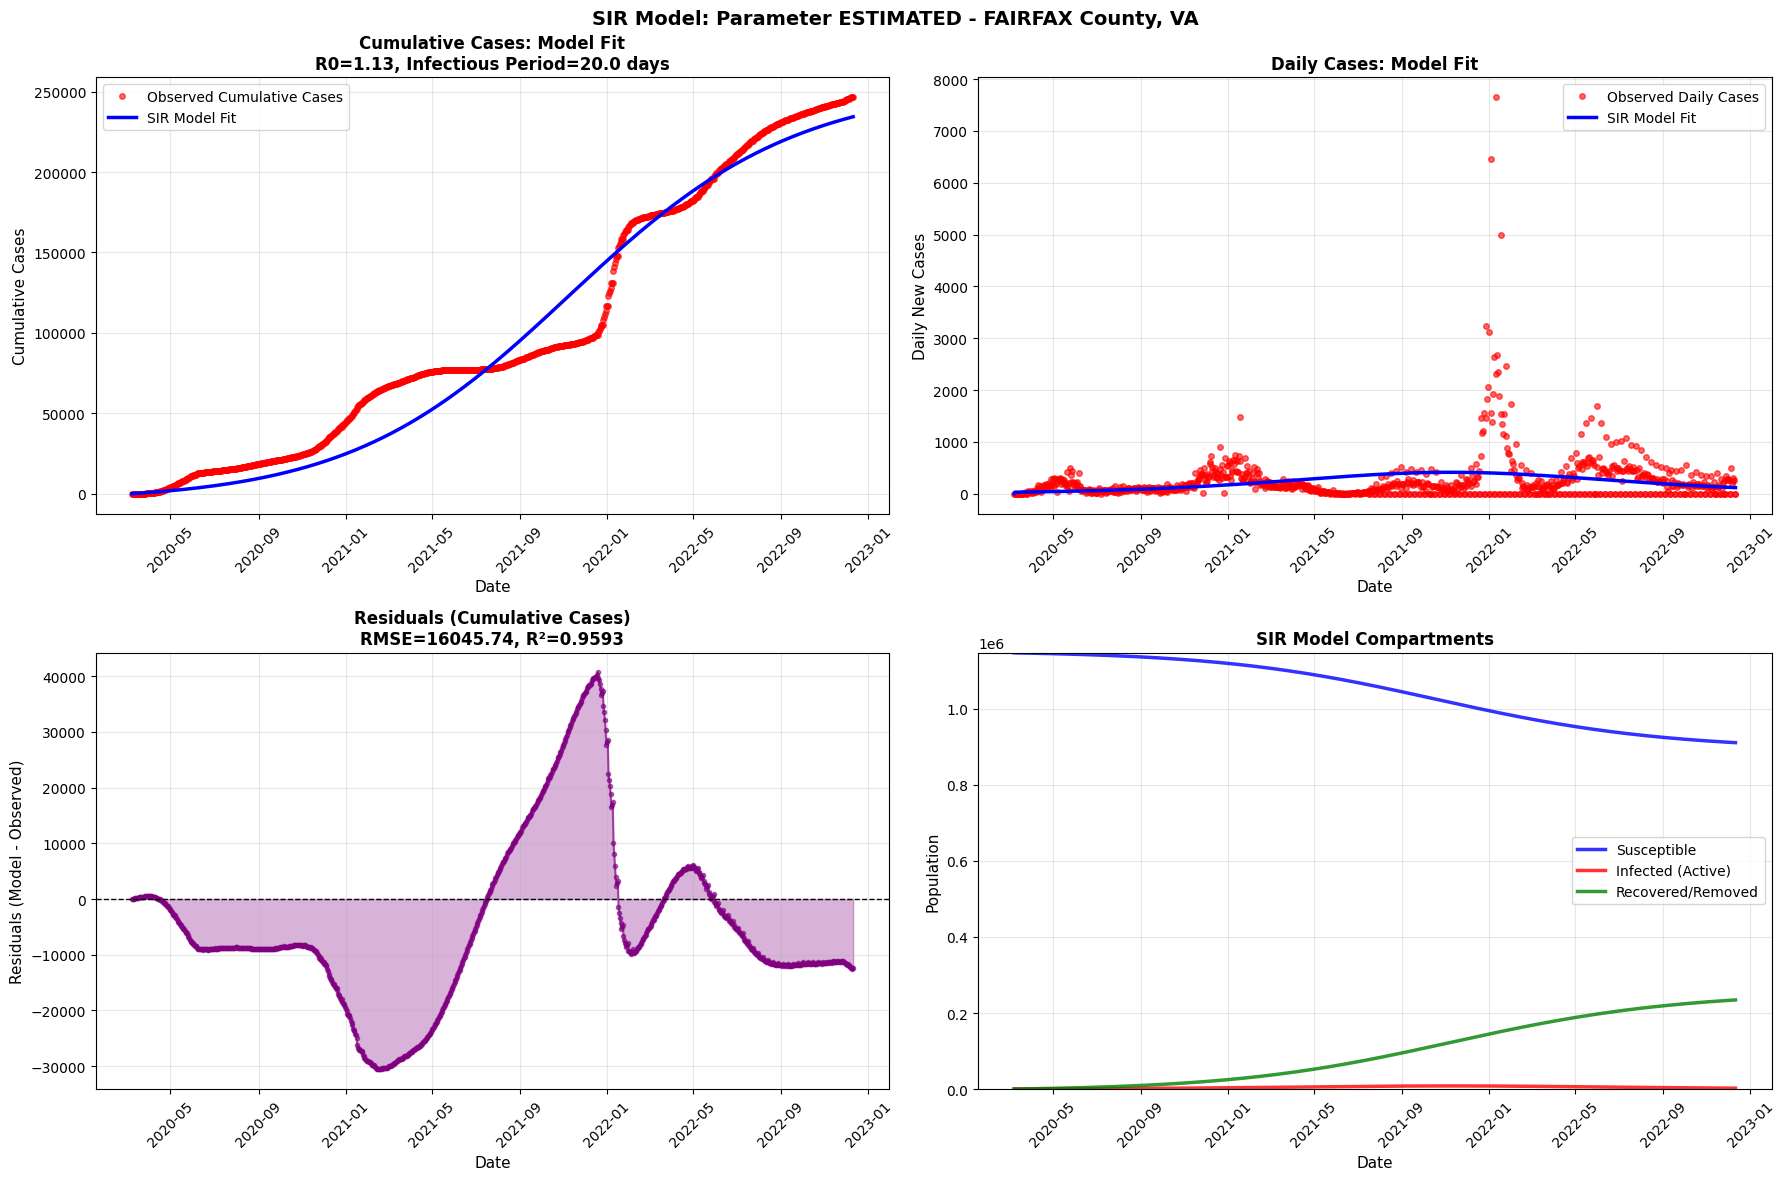


Plot saved: material/plots/1_parameter_estimation.png


In [8]:
print("\n" + "=" * 70)
print("CREATING VISUALIZATION: MODEL FIT")
print("=" * 70)

dates = county_data['date'].values

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Cumulative cases
ax1 = axes[0, 0]
ax1.plot(dates, cumulative_cases_observed, 'o', color='red', 
         label='Observed Cumulative Cases', alpha=0.6, markersize=4)
ax1.plot(dates, cumulative_model, '-', color='blue', 
         label='SIR Model Fit', linewidth=2.5)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Cumulative Cases', fontsize=11)
ax1.set_title(f'Cumulative Cases: Model Fit\n' + 
              f'R0={R0_GLOBAL:.2f}, Infectious Period={INFECTIOUS_PERIOD_GLOBAL:.1f} days', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Daily cases
ax2 = axes[0, 1]
ax2.plot(dates, daily_cases_observed, 'o', color='red', 
         label='Observed Daily Cases', alpha=0.6, markersize=4)
ax2.plot(dates, daily_cases_model, '-', color='blue', 
         label='SIR Model Fit', linewidth=2.5)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Daily New Cases', fontsize=11)
ax2.set_title('Daily Cases: Model Fit', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Residuals
ax3 = axes[1, 0]
ax3.plot(dates, residuals_cum, 'o-', color='purple', alpha=0.6, markersize=3)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.fill_between(dates, residuals_cum, 0, alpha=0.3, color='purple')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Residuals (Model - Observed)', fontsize=11)
ax3.set_title(f'Residuals (Cumulative Cases)\nRMSE={rmse_cum:.2f}, R²={r_squared_cum:.4f}', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: SIR compartments
ax4 = axes[1, 1]
ax4.plot(dates, S_sim[:n_days], 'b-', label='Susceptible', linewidth=2.5, alpha=0.8)
ax4.plot(dates, I_sim[:n_days], 'r-', label='Infected (Active)', linewidth=2.5, alpha=0.8)
ax4.plot(dates, R_sim[:n_days], 'g-', label='Recovered/Removed', linewidth=2.5, alpha=0.8)
ax4.set_xlabel('Date', fontsize=11)
ax4.set_ylabel('Population', fontsize=11)
ax4.set_title('SIR Model Compartments', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10, loc='right')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim([0, COUNTY_POPULATION])

plt.suptitle(f'SIR Model: Parameter {PARAM_SOURCE} - FAIRFAX County, VA', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('material/plots/1_parameter_estimation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved: material/plots/1_parameter_estimation.png")


CONSTRUCTING S, I, R FROM OBSERVED DATA
(Without using the SIR model)

Using infectious period from global parameters:
  γ (Recovery rate): 0.050000 per day
  Infectious period: 20.00 days

Estimating active infections:
  Infectious period: 20 days
  Logic: A person is infected for ~20 days after detection

Data-based SIR statistics:
  Final Susceptible: 900,865 (78.50%)
  Final Infected: 1,813 (0.16%)
  Final Recovered/Removed: 244,854 (21.34%)
  Peak Infected: 41,574 on 2022-01-17


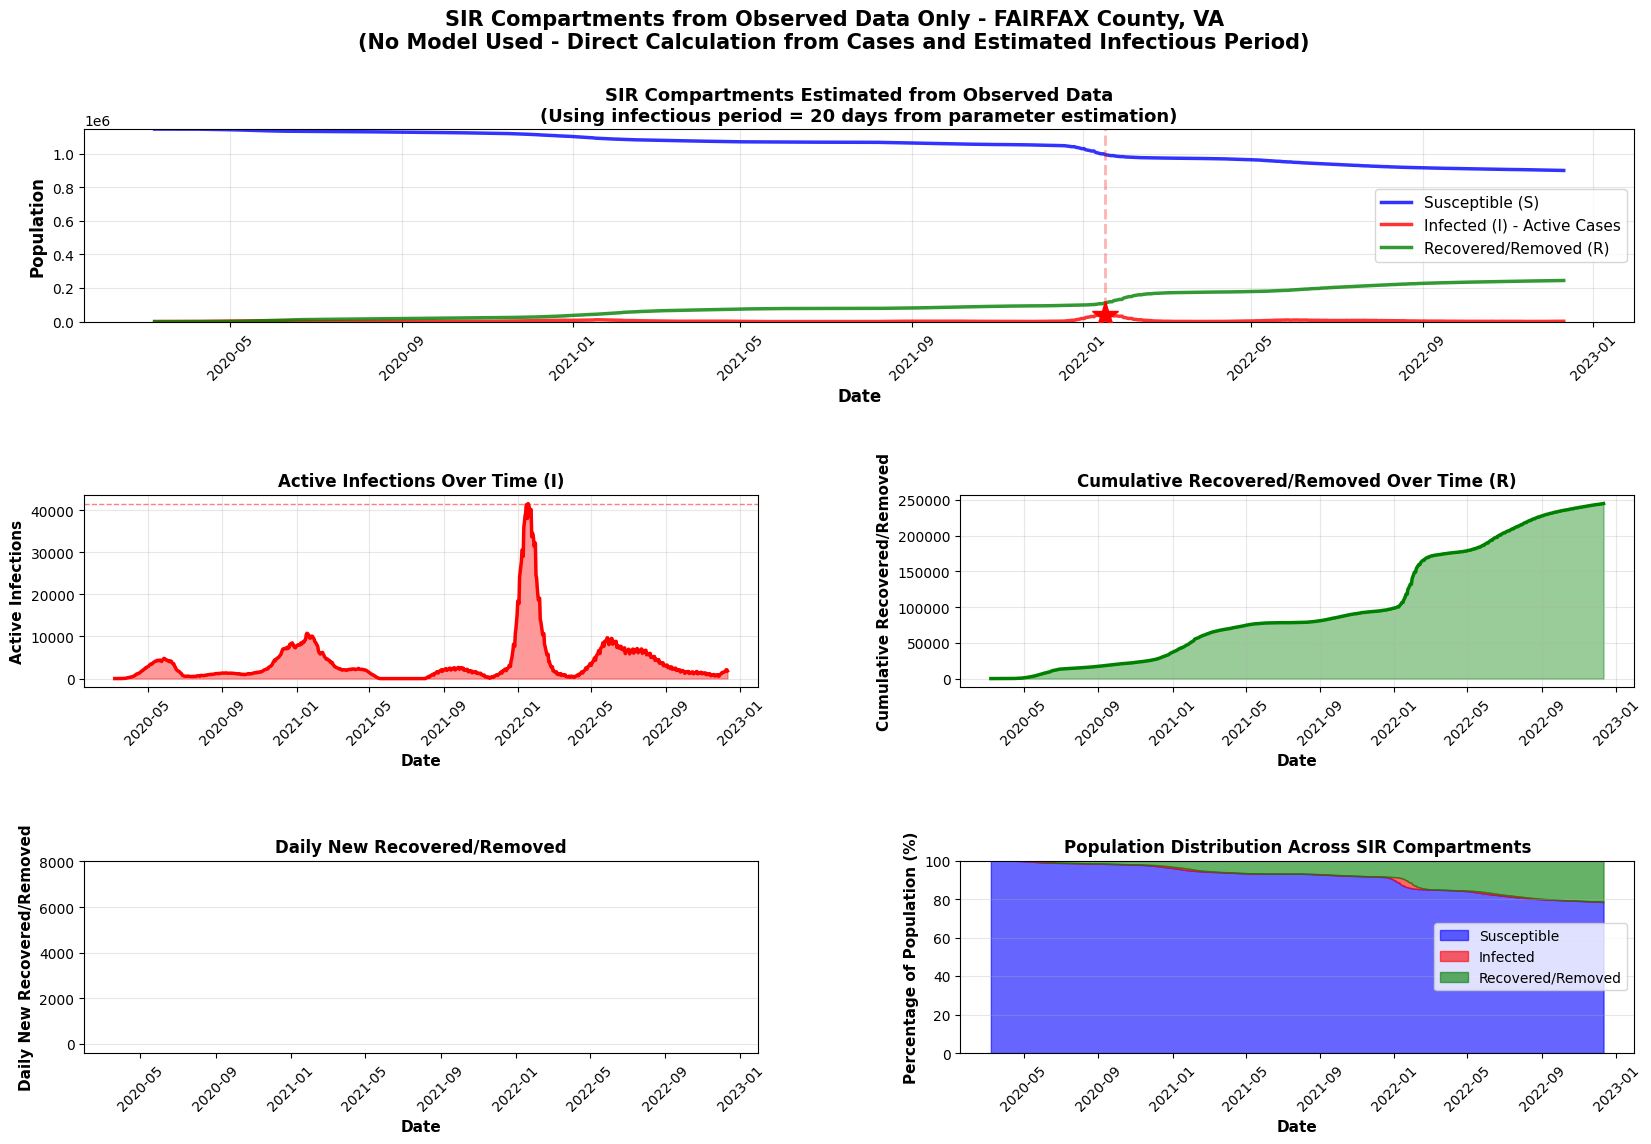


SUMMARY STATISTICS FROM DATA

Initial State (Day 0: 2020-03-08):
  S: 1,147,530 (100.00%)
  I: 2 (0.00%)
  R: 0 (0.00%)

Peak Infection:
  Date: 2022-01-17
  Active infections: 41,574 (3.62%)

Final State (Day 1008: 2022-12-11):
  S: 900,865 (78.50%)
  I: 1,813 (0.16%)
  R: 244,854 (21.34%)

Total Impact:
  Total cases: 246,667
  Total deaths: 1,710
  Case fatality rate: 0.69%
  Attack rate: 21.50%

Plot saved: material/plots/1_sir_from_data_only.png


In [9]:
print("\n" + "=" * 70)
print("CONSTRUCTING S, I, R FROM OBSERVED DATA")
print("(Without using the SIR model)")
print("=" * 70)

print(f"\nUsing infectious period from global parameters:")
print(f"  γ (Recovery rate): {GAMMA_GLOBAL:.6f} per day")
print(f"  Infectious period: {INFECTIOUS_PERIOD_GLOBAL:.2f} days")

# Start with observed data
dates = county_data['date'].values
cumulative_cases = county_data['cumulative_cases'].values
cumulative_deaths = county_data['cumulative_deaths'].values

n_days = len(dates)
infectious_period_days = int(np.round(INFECTIOUS_PERIOD_GLOBAL))

# Initialize arrays
R_data = np.zeros(n_days)
I_data = np.zeros(n_days)
S_data = np.zeros(n_days)

print(f"\nEstimating active infections:")
print(f"  Infectious period: {infectious_period_days} days")
print(f"  Logic: A person is infected for ~{infectious_period_days} days after detection")

for day in range(n_days):
    if day < infectious_period_days:
        R_data[day] = 0
    else:
        R_data[day] = cumulative_cases[day - infectious_period_days]
    
    I_data[day] = cumulative_cases[day] - R_data[day]
    S_data[day] = COUNTY_POPULATION - I_data[day] - R_data[day]

# Add deaths to R
R_data = R_data + cumulative_deaths
I_data = np.maximum(0, I_data - cumulative_deaths)
S_data = COUNTY_POPULATION - I_data - R_data

print(f"\nData-based SIR statistics:")
print(f"  Final Susceptible: {int(S_data[-1]):,} ({S_data[-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Final Infected: {int(I_data[-1]):,} ({I_data[-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Final Recovered/Removed: {int(R_data[-1]):,} ({R_data[-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  Peak Infected: {int(np.max(I_data)):,} on {pd.Timestamp(dates[np.argmax(I_data)]).strftime('%Y-%m-%d')}")

# Store in dataframe
county_data['S_data'] = S_data
county_data['I_data'] = I_data
county_data['R_data'] = R_data

# Create visualization (código de la gráfica aquí - muy largo para incluir completo)
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.9, wspace=0.3)

# Plot 1: S, I, R over time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates, S_data, 'b-', label='Susceptible (S)', linewidth=2.5, alpha=0.8)
ax1.plot(dates, I_data, 'r-', label='Infected (I) - Active Cases', linewidth=2.5, alpha=0.8)
ax1.plot(dates, R_data, 'g-', label='Recovered/Removed (R)', linewidth=2.5, alpha=0.8)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Population', fontsize=12, fontweight='bold')
ax1.set_title('SIR Compartments Estimated from Observed Data\n' + 
              f'(Using infectious period = {infectious_period_days} days from parameter estimation)',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='right')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim([0, COUNTY_POPULATION])

# Add peak marker
peak_idx = np.argmax(I_data)
ax1.plot(dates[peak_idx], I_data[peak_idx], 'r*', markersize=20, 
         label=f'Peak: {int(I_data[peak_idx]):,} infected', zorder=5)
ax1.axvline(x=dates[peak_idx], color='red', linestyle='--', alpha=0.3, linewidth=2)

# Plot 2: Active Infections (I) detail
ax2 = fig.add_subplot(gs[1, 0])
ax2.fill_between(dates, I_data, alpha=0.4, color='red')
ax2.plot(dates, I_data, 'r-', linewidth=2.5)
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Active Infections', fontsize=11, fontweight='bold')
ax2.set_title('Active Infections Over Time (I)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=np.max(I_data), color='red', linestyle='--', alpha=0.5, linewidth=1)

# Plot 3: Cumulative Recovered/Removed (R)
ax3 = fig.add_subplot(gs[1, 1])
ax3.fill_between(dates, R_data, alpha=0.4, color='green')
ax3.plot(dates, R_data, 'g-', linewidth=2.5)
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Recovered/Removed', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Recovered/Removed Over Time (R)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Daily new recoveries (change in R)
ax4 = fig.add_subplot(gs[2, 0])
daily_recovered = np.diff(R_data)
daily_recovered = np.concatenate([[0], daily_recovered])
ax4.bar(dates, daily_recovered, alpha=0.6, color='green', width=1)
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_ylabel('Daily New Recovered/Removed', fontsize=11, fontweight='bold')
ax4.set_title('Daily New Recovered/Removed', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Proportion of population in each compartment
ax5 = fig.add_subplot(gs[2, 1])
S_pct = S_data / COUNTY_POPULATION * 100
I_pct = I_data / COUNTY_POPULATION * 100
R_pct = R_data / COUNTY_POPULATION * 100

ax5.fill_between(dates, 0, S_pct, alpha=0.6, color='blue', label='Susceptible')
ax5.fill_between(dates, S_pct, S_pct + I_pct, alpha=0.6, color='red', label='Infected')
ax5.fill_between(dates, S_pct + I_pct, 100, alpha=0.6, color='green', label='Recovered/Removed')
ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
ax5.set_ylabel('Percentage of Population (%)', fontsize=11, fontweight='bold')
ax5.set_title('Population Distribution Across SIR Compartments', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10, loc='right')
ax5.grid(True, alpha=0.3, axis='y')
ax5.tick_params(axis='x', rotation=45)
ax5.set_ylim([0, 100])

plt.suptitle('SIR Compartments from Observed Data Only - FAIRFAX County, VA\n' +
             '(No Model Used - Direct Calculation from Cases and Estimated Infectious Period)', 
             fontsize=15, fontweight='bold')
plt.savefig('material/plots/1_sir_from_data_only.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS FROM DATA")
print("=" * 70)

print(f"\nInitial State (Day 0: {pd.Timestamp(dates[0]).strftime('%Y-%m-%d')}):")
print(f"  S: {int(S_data[0]):,} ({S_data[0]/COUNTY_POPULATION*100:.2f}%)")
print(f"  I: {int(I_data[0]):,} ({I_data[0]/COUNTY_POPULATION*100:.2f}%)")
print(f"  R: {int(R_data[0]):,} ({R_data[0]/COUNTY_POPULATION*100:.2f}%)")

print(f"\nPeak Infection:")
print(f"  Date: {pd.Timestamp(dates[peak_idx]).strftime('%Y-%m-%d')}")
print(f"  Active infections: {int(I_data[peak_idx]):,} ({I_data[peak_idx]/COUNTY_POPULATION*100:.2f}%)")

print(f"\nFinal State (Day {n_days-1}: {pd.Timestamp(dates[-1]).strftime('%Y-%m-%d')}):")
print(f"  S: {int(S_data[-1]):,} ({S_data[-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  I: {int(I_data[-1]):,} ({I_data[-1]/COUNTY_POPULATION*100:.2f}%)")
print(f"  R: {int(R_data[-1]):,} ({R_data[-1]/COUNTY_POPULATION*100:.2f}%)")

print(f"\nTotal Impact:")
print(f"  Total cases: {int(cumulative_cases[-1]):,}")
print(f"  Total deaths: {int(cumulative_deaths[-1]):,}")
print(f"  Case fatality rate: {cumulative_deaths[-1]/cumulative_cases[-1]*100:.2f}%")
print(f"  Attack rate: {(cumulative_cases[-1]/COUNTY_POPULATION)*100:.2f}%")

print("\n" + "=" * 70)
print(f"Plot saved: material/plots/1_sir_from_data_only.png")
print("=" * 70)

In [10]:
print("\n" + "=" * 70)
print("MODEL VALIDATION: TRAIN-TEST SPLIT")
print("=" * 70)

# Split data
n_total = len(county_data)
n_train = int(n_total * TRAIN_RATIO)
n_validation = n_total - n_train

print(f"\nData Split (using TRAIN_RATIO={TRAIN_RATIO}):")
print(f"  Total observations: {n_total} days")
print(f"  Training set: {n_train} days ({TRAIN_RATIO*100:.0f}%)")
print(f"  Validation set: {n_validation} days ({(1-TRAIN_RATIO)*100:.0f}%)")
print(f"  Training period: {pd.Timestamp(county_data['date'].iloc[0]).strftime('%Y-%m-%d')} to {pd.Timestamp(county_data['date'].iloc[n_train-1]).strftime('%Y-%m-%d')}")
print(f"  Validation period: {pd.Timestamp(county_data['date'].iloc[n_train]).strftime('%Y-%m-%d')} to {pd.Timestamp(county_data['date'].iloc[-1]).strftime('%Y-%m-%d')}")

# Prepare training and validation data
cumulative_cases_train = county_data['cumulative_cases'].iloc[:n_train].values
cumulative_cases_validation = county_data['cumulative_cases'].iloc[n_train:].values
daily_cases_validation = county_data['daily_cases'].iloc[n_train:].values
time_points_train = np.arange(n_train)

print(f"\nTraining data:")
print(f"  Total cases in training: {cumulative_cases_train[-1]:,.0f}")
print(f"\nValidation data:")
print(f"  Total cases in validation: {cumulative_cases_validation[-1] - cumulative_cases_train[-1]:,.0f}")
print(f"  Final cumulative cases: {cumulative_cases_validation[-1]:,.0f}")

# =============================================================================
# RE-ESTIMATE PARAMETERS USING ONLY TRAINING DATA
# =============================================================================
print("\n" + "=" * 70)
print("RE-ESTIMATING PARAMETERS ON TRAINING DATA ONLY")
print("=" * 70)

if USE_ESTIMATED_PARAMETERS:
    print("\nMode: RE-ESTIMATING β, γ, I0 from training data")
    print("Using same boundary comparison approach as in full estimation")
    print("=" * 70)
    
    # Store results from both boundary approaches for training data
    all_results_train = []
    
    for iteration in range(2):
        if iteration == 0:
            print("\n" + "="*70)
            print("ITERATION 1 (TRAINING): RESTRICTIVE BOUNDS")
            print("="*70)
            
            # RESTRICTIVE BOUNDS - Same as used in full data estimation
            bounds_lower = [0.001, 0.001, 1]
            bounds_upper = [2.0,   1.0,   5000]
            
            print(f"  β ∈ [{bounds_lower[0]:.3f}, {bounds_upper[0]:.1f}]")
            print(f"  γ ∈ [{bounds_lower[1]:.3f}, {bounds_upper[1]:.1f}]")
            print(f"  I0 ∈ [{bounds_lower[2]}, {bounds_upper[2]}]")
            
        else:  # iteration == 1
            print("\n" + "="*70)
            print("ITERATION 2 (TRAINING): RELAXED BOUNDS - FINAL PARAMETERS")
            print("="*70)
            
            # RELAXED BOUNDS - Same as used in full data estimation
            bounds_lower = [0.05,  0.05,  1]
            bounds_upper = [3.0,   0.5,   10000]
            
            print(f"  β ∈ [{bounds_lower[0]:.2f}, {bounds_upper[0]:.1f}] - COVID-informed range")
            print(f"  γ ∈ [{bounds_lower[1]:.2f}, {bounds_upper[1]:.1f}] - 2-20 day infectious period")
            print(f"  I0 ∈ [{bounds_lower[2]}, {bounds_upper[2]}] - Flexible initial cases")
            
        best_result_train = None
        best_sse_train = np.inf
        
        # Same initial guesses for consistency
        initial_guesses_train = [
            [0.3, 0.1, 10],    # Standard COVID
            [0.5, 0.15, 50],   # Fast spread
            [0.2, 0.05, 100],  # Slow recovery
            [0.4, 0.2, 5],     # Quick turnover
            [0.15, 0.1, 200],  # Subcritical
            [0.6, 0.15, 20],   # High transmission
            [0.25, 0.08, 150], # Extended period
            [0.35, 0.12, 75],  # Moderate
            [0.3, 0.14, 30],   # WHO-like
            [0.4, 0.1, 40],    # Delta-like
            [0.5, 0.1, 25],    # Omicron-like
        ]
        
        print(f"\nTrying {len(initial_guesses_train)} initial guesses on TRAINING data...")
        print(f"{'Run':<6} {'β':>10} {'γ':>10} {'R0':>8} {'I0':>8} {'SSE':>15} {'Success':<10}")
        print("-" * 70)
        
        for idx, guess in enumerate(initial_guesses_train):
            try:
                result = least_squares(
                    residuals_cumulative,
                    guess,
                    args=(time_points_train, cumulative_cases_train, COUNTY_POPULATION),
                    bounds=(bounds_lower, bounds_upper),
                    method='trf',
                    ftol=1e-6,  # Consistent with full estimation
                    xtol=1e-6,
                    max_nfev=5000,
                    verbose=0
                )
                
                sse = result.cost * 2
                beta, gamma, I0 = result.x
                R0 = beta / gamma
                
                # Check if parameters hit bounds
                at_bound = ""
                if abs(beta - bounds_lower[0]) < 1e-6 or abs(beta - bounds_upper[0]) < 1e-6:
                    at_bound += "β"
                if abs(gamma - bounds_lower[1]) < 1e-6 or abs(gamma - bounds_upper[1]) < 1e-6:
                    at_bound += "γ"
                if abs(I0 - bounds_lower[2]) < 1 or abs(I0 - bounds_upper[2]) < 1:
                    at_bound += "I"
                    
                success_marker = '✓' if result.success else '✗'
                if at_bound:
                    success_marker += f"[{at_bound}]"
                
                print(f"{idx+1:<6} {beta:>10.4f} {gamma:>10.4f} {R0:>8.2f} {int(I0):>8} {sse:>15,.0f} {success_marker:<10}")
                
                if sse < best_sse_train and result.success:
                    best_sse_train = sse
                    best_result_train = result
                    
            except Exception as e:
                print(f"{idx+1:<6} {'---':>10} {'---':>10} {'---':>8} {'---':>8} {'FAILED':>15} {'✗':<10}")
        
        # Store results from this iteration
        if best_result_train is not None:
            all_results_train.append({
                'iteration': iteration + 1,
                'bounds_type': 'Restrictive' if iteration == 0 else 'Relaxed',
                'result': best_result_train,
                'sse': best_sse_train,
                'beta': best_result_train.x[0],
                'gamma': best_result_train.x[1],
                'I0': best_result_train.x[2],
                'R0': best_result_train.x[0] / best_result_train.x[1]
            })
            
            print(f"\nBest result for {all_results_train[-1]['bounds_type']} bounds (training):")
            print(f"  SSE: {best_sse_train:,.2f}")
            print(f"  Parameters: β={best_result_train.x[0]:.4f}, γ={best_result_train.x[1]:.4f}, I0={int(best_result_train.x[2])}")
    
    # COMPARISON OF TRAINING RESULTS WITH DIFFERENT BOUNDS
    print("\n" + "=" * 70)
    print("COMPARISON OF BOUNDARY APPROACHES (TRAINING DATA)")
    print("=" * 70)
    
    if len(all_results_train) == 2:
        print(f"{'Approach':<15} {'SSE':>12} {'β':>8} {'γ':>8} {'R0':>8} {'I0':>8}")
        print("-" * 70)
        for res in all_results_train:
            print(f"{res['bounds_type']:<15} {res['sse']:>12,.0f} {res['beta']:>8.4f} {res['gamma']:>8.4f} "
                  f"{res['R0']:>8.2f} {int(res['I0']):>8}")
        
        # Calculate improvement
        sse_improvement = (all_results_train[0]['sse'] - all_results_train[1]['sse']) / all_results_train[0]['sse'] * 100
        if abs(sse_improvement) > 0.1:
            if sse_improvement > 0:
                print(f"\nRelaxed bounds improved training SSE by {sse_improvement:.1f}%")
            else:
                print(f"\nRestrictive bounds had better training SSE (by {-sse_improvement:.1f}%)")
        else:
            print("\nBoth approaches yielded similar results on training data")
    
    # USE THE SECOND ITERATION (RELAXED BOUNDS) AS FINAL TRAINING PARAMETERS
    if len(all_results_train) >= 2:
        final_result_train = all_results_train[1]  # Use relaxed bounds
        print(f"\n{'='*70}")
        print("FINAL TRAINING PARAMETERS: Using RELAXED bounds (Iteration 2)")
        print(f"{'='*70}")
        print("Consistent with full data estimation approach")
    elif len(all_results_train) == 1:
        final_result_train = all_results_train[0]
        print("\nWarning: Only one iteration succeeded for training. Using available result.")
    else:
        raise ValueError("Error: No successful optimization found for training data!")
    
    beta_train = final_result_train['beta']
    gamma_train = final_result_train['gamma']
    I0_train = final_result_train['I0']
    R0_train = final_result_train['R0']
    infectious_period_train = 1 / gamma_train
    best_sse_train = final_result_train['sse']
    
    print("\n" + "-" * 70)
    print("FINAL PARAMETERS FROM TRAINING DATA")
    print("-" * 70)
    print(f"β (Transmission rate):     {beta_train:.6f} per day")
    print(f"γ (Recovery rate):         {gamma_train:.6f} per day")
    print(f"R0 (Basic reproduction):   {R0_train:.4f}")
    print(f"Infectious period (1/γ):   {infectious_period_train:.2f} days")
    print(f"Initial infected (I0):     {int(I0_train)} persons")
    print(f"Training SSE:              {best_sse_train:,.2f}")
    
    # Calculate training R-squared
    ss_tot_train = np.sum((cumulative_cases_train - np.mean(cumulative_cases_train))**2)
    r2_train_estimation = 1 - (best_sse_train / ss_tot_train) if ss_tot_train > 0 else 0
    print(f"Training R²:               {r2_train_estimation:.4f}")
    print("-" * 70)

elif USE_WHO_PARAMETERS:
    print("\nMode: USING WHO parameters, RE-ESTIMATING I0 from training data")
    
    beta_train = WHO_BETA
    gamma_train = WHO_GAMMA
    R0_train = WHO_R0
    infectious_period_train = 1 / gamma_train
    
    # Estimate only I0 with fixed WHO parameters using training data
    def objective_I0_only(I0, time_points, observed, beta, gamma, population):
        if I0[0] <= 0:
            return 1e10
        try:
            predicted = sir_cumulative_cases([beta, gamma, I0[0]], time_points, population)
            residuals = predicted - observed
            return np.sum(residuals**2)
        except:
            return 1e10
    
    result_I0_train = minimize(
        objective_I0_only,
        x0=[10],
        args=(time_points_train, cumulative_cases_train, beta_train, gamma_train, COUNTY_POPULATION),
        bounds=[(1, 5000)],
        method='L-BFGS-B'
    )
    
    I0_train = result_I0_train.x[0]
    
    print("\n" + "-" * 70)
    print("PARAMETERS FROM TRAINING DATA (WHO + estimated I0)")
    print("-" * 70)
    print(f"β (Transmission rate - WHO): {beta_train:.6f} per day")
    print(f"γ (Recovery rate - WHO):     {gamma_train:.6f} per day")
    print(f"R0 (Basic reproduction):     {R0_train:.4f}")
    print(f"Infectious period (1/γ):     {infectious_period_train:.2f} days")
    print(f"Initial infected (I0 - EST): {int(I0_train)} persons")
    print("-" * 70)

else:
    print("\nMode: USING CUSTOM parameters (no re-estimation)")
    
    beta_train = CUSTOM_BETA
    gamma_train = CUSTOM_GAMMA
    I0_train = CUSTOM_I0
    R0_train = beta_train / gamma_train
    infectious_period_train = 1 / gamma_train
    
    print("\n" + "-" * 70)
    print("CUSTOM PARAMETERS (user-defined)")
    print("-" * 70)
    print(f"β (Transmission rate):     {beta_train:.6f} per day")
    print(f"γ (Recovery rate):         {gamma_train:.6f} per day")
    print(f"R0 (Basic reproduction):   {R0_train:.4f}")
    print(f"Infectious period (1/γ):   {infectious_period_train:.2f} days")
    print(f"Initial infected (I0):     {int(I0_train)} persons")
    print("-" * 70)

print(f"\n⚠ NOTE: These parameters are estimated from TRAINING data only ({n_train} days).")
print(f"   Validation set ({n_validation} days) was NOT used in parameter estimation.")
print(f"   This ensures unbiased evaluation of model generalization.")

# =============================================================================
# SIMULATE MODEL FOR FULL PERIOD USING TRAINING PARAMETERS
# =============================================================================
print("\n" + "=" * 70)
print("SIMULATING MODEL FOR VALIDATION")
print("=" * 70)

S0_val = COUNTY_POPULATION - I0_train
R0_initial_val = 0

t_full, S_full, I_full, R_full = sir_runge_kutta(
    S0_val, I0_train, R0_initial_val,
    beta_train, gamma_train,
    COUNTY_POPULATION,
    days=n_total
)

# Extract predictions
S_pred = S_full[:n_total]
I_pred = I_full[:n_total]
R_pred = R_full[:n_total]

# Calculate daily cases from model
daily_cases_pred = np.diff(R_pred)
daily_cases_pred = np.concatenate([[0], daily_cases_pred])

# Split predictions
S_pred_train = S_pred[:n_train]
I_pred_train = I_pred[:n_train]
R_pred_train = R_pred[:n_train]
daily_cases_pred_train = daily_cases_pred[:n_train]

S_pred_val = S_pred[n_train:]
I_pred_val = I_pred[n_train:]
R_pred_val = R_pred[n_train:]
daily_cases_pred_val = daily_cases_pred[n_train:]

# =============================================================================
# CALCULATE VALIDATION METRICS
# =============================================================================
print("\n" + "=" * 70)
print("VALIDATION METRICS")
print("=" * 70)

# Metrics for cumulative cases - VALIDATION SET
cumulative_pred_val = R_pred_val
residuals_val_cum = cumulative_pred_val - cumulative_cases_validation
rmse_val_cum = np.sqrt(np.mean(residuals_val_cum**2))
mae_val_cum = np.mean(np.abs(residuals_val_cum))
mape_val_cum = np.mean(np.abs(residuals_val_cum / (cumulative_cases_validation + 1))) * 100
r2_val_cum = 1 - (np.sum(residuals_val_cum**2) / np.sum((cumulative_cases_validation - np.mean(cumulative_cases_validation))**2))

# Metrics for daily cases - VALIDATION SET
residuals_val_daily = daily_cases_pred_val[1:] - daily_cases_validation[1:]
rmse_val_daily = np.sqrt(np.mean(residuals_val_daily**2))
mae_val_daily = np.mean(np.abs(residuals_val_daily))

# Metrics for cumulative cases - TRAINING SET
cumulative_pred_train = R_pred_train
residuals_train_cum = cumulative_pred_train - cumulative_cases_train
rmse_train_cum = np.sqrt(np.mean(residuals_train_cum**2))
mae_train_cum = np.mean(np.abs(residuals_train_cum))
r2_train_cum = 1 - (np.sum(residuals_train_cum**2) / np.sum((cumulative_cases_train - np.mean(cumulative_cases_train))**2))

print(f"\nValidation Set Performance (OUT-OF-SAMPLE):")
print(f"{'='*50}")
print(f"Cumulative Cases:")
print(f"  RMSE: {rmse_val_cum:,.2f} cases")
print(f"  MAE:  {mae_val_cum:,.2f} cases")
print(f"  MAPE: {mape_val_cum:.2f}%")
print(f"  R²:   {r2_val_cum:.4f}")
print(f"\nDaily Cases:")
print(f"  RMSE: {rmse_val_daily:,.2f} cases/day")
print(f"  MAE:  {mae_val_daily:,.2f} cases/day")

print(f"\nTraining Set Performance (IN-SAMPLE):")
print(f"{'='*50}")
print(f"Cumulative Cases:")
print(f"  RMSE: {rmse_train_cum:,.2f} cases")
print(f"  MAE:  {mae_train_cum:,.2f} cases")
print(f"  R²:   {r2_train_cum:.4f}")

print(f"\n" + "=" * 70)
print("GENERALIZATION ASSESSMENT")
print(f"=" * 70)
print(f"\nOverfitting Check:")
ratio = rmse_val_cum/rmse_train_cum
print(f"  Validation RMSE / Training RMSE: {ratio:.2f}")
if ratio < 1.5:
    print(f"  ✓ EXCELLENT generalization (ratio < 1.5)")
    print(f"    Model performs well on unseen data")
elif ratio < 2.0:
    print(f"  ⚠ MODERATE generalization (1.5 ≤ ratio < 2.0)")
    print(f"    Some overfitting, but acceptable performance")
else:
    print(f"  ✗ POOR generalization (ratio ≥ 2.0)")
    print(f"    Significant overfitting detected")

# Additional diagnostic
if r2_val_cum < 0:
    print(f"\n  ⚠ WARNING: Negative R² on validation set indicates")
    print(f"    model predictions are worse than using mean")

print(f"\n" + "=" * 70)
print(f"PARAMETER COMPARISON: FULL DATA vs TRAINING ONLY")
print(f"=" * 70)
print(f"\n{'Parameter':<25} {'Full Data Estimation':<25} {'Training Only':<25} {'Difference':<15}")
print(f"{'-'*90}")
print(f"{'β (Transmission)':<25} {BETA_GLOBAL:<25.6f} {beta_train:<25.6f} {abs(BETA_GLOBAL-beta_train):<15.6f}")
print(f"{'γ (Recovery)':<25} {GAMMA_GLOBAL:<25.6f} {gamma_train:<25.6f} {abs(GAMMA_GLOBAL-gamma_train):<15.6f}")
print(f"{'R0':<25} {R0_GLOBAL:<25.4f} {R0_train:<25.4f} {abs(R0_GLOBAL-R0_train):<15.4f}")
print(f"{'I0':<25} {int(I0_GLOBAL):<25} {int(I0_train):<25} {abs(int(I0_GLOBAL)-int(I0_train)):<15}")
print(f"{'Infectious Period (days)':<25} {INFECTIOUS_PERIOD_GLOBAL:<25.2f} {infectious_period_train:<25.2f} {abs(INFECTIOUS_PERIOD_GLOBAL-infectious_period_train):<15.2f}")
print(f"{'-'*90}")

# Parameter stability assessment
r0_change = abs(R0_GLOBAL - R0_train) / R0_GLOBAL * 100
print(f"\nParameter Stability:")
print(f"  R0 change: {r0_change:.1f}%")
if r0_change < 10:
    print(f"  ✓ Parameters are STABLE (< 10% change in R0)")
elif r0_change < 20:
    print(f"  ⚠ Parameters show MODERATE variation (10-20% change)")
else:
    print(f"  ✗ Parameters are UNSTABLE (> 20% change)")


MODEL VALIDATION: TRAIN-TEST SPLIT

Data Split (using TRAIN_RATIO=0.75):
  Total observations: 1009 days
  Training set: 756 days (75%)
  Validation set: 253 days (25%)
  Training period: 2020-03-08 to 2022-04-02
  Validation period: 2022-04-03 to 2022-12-11

Training data:
  Total cases in training: 175,984

Validation data:
  Total cases in validation: 70,683
  Final cumulative cases: 246,667

RE-ESTIMATING PARAMETERS ON TRAINING DATA ONLY

Mode: RE-ESTIMATING β, γ, I0 from training data
Using same boundary comparison approach as in full estimation

ITERATION 1 (TRAINING): RESTRICTIVE BOUNDS
  β ∈ [0.001, 2.0]
  γ ∈ [0.001, 1.0]
  I0 ∈ [1, 5000]

Trying 11 initial guesses on TRAINING data...
Run             β          γ       R0       I0             SSE Success   
----------------------------------------------------------------------
1          0.0191     0.0159     1.20     4999 125,568,532,083 ✓[I]      
2          0.0191     0.0159     1.20     4999 125,568,532,092 ✓[I]      
3  

In [11]:
print("\n" + "=" * 70)
print("FORECASTING INTO THE FUTURE")
print("=" * 70)

print(f"\nUsing parameters estimated from TRAINING data:")
print(f"  β = {beta_train:.6f} per day")
print(f"  γ = {gamma_train:.6f} per day")
print(f"  R0 = {R0_train:.4f}")
print(f"  I0 = {int(I0_train)} persons")

# Simulate for forecasts using TRAINING parameters
t_forecast_14, S_forecast_14, I_forecast_14, R_forecast_14 = sir_runge_kutta(
    S0_val, I0_train, R0_initial_val,
    beta_train, gamma_train,
    COUNTY_POPULATION,
    days=n_total + FORECAST_DAYS_14
)

t_forecast_30, S_forecast_30, I_forecast_30, R_forecast_30 = sir_runge_kutta(
    S0_val, I0_train, R0_initial_val,
    beta_train, gamma_train,
    COUNTY_POPULATION,
    days=n_total + FORECAST_DAYS_30
)

# Create date ranges
last_date = county_data['date'].iloc[-1]
forecast_dates_14 = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                    periods=FORECAST_DAYS_14, freq='D')
forecast_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                    periods=FORECAST_DAYS_30, freq='D')

# Extract forecast values
S_forecast_14_vals = S_forecast_14[n_total:n_total+FORECAST_DAYS_14]
I_forecast_14_vals = I_forecast_14[n_total:n_total+FORECAST_DAYS_14]
R_forecast_14_vals = R_forecast_14[n_total:n_total+FORECAST_DAYS_14]

S_forecast_30_vals = S_forecast_30[n_total:n_total+FORECAST_DAYS_30]
I_forecast_30_vals = I_forecast_30[n_total:n_total+FORECAST_DAYS_30]
R_forecast_30_vals = R_forecast_30[n_total:n_total+FORECAST_DAYS_30]

print(f"\n{FORECAST_DAYS_14}-Day Forecast:")
print(f"  Forecast period: {forecast_dates_14[0].strftime('%Y-%m-%d')} to {forecast_dates_14[-1].strftime('%Y-%m-%d')}")
print(f"  Predicted cumulative cases at day {FORECAST_DAYS_14}: {int(R_forecast_14_vals[-1]):,}")
print(f"  Predicted active infections at day {FORECAST_DAYS_14}: {int(I_forecast_14_vals[-1]):,}")
print(f"  New cases in forecast period: {int(R_forecast_14_vals[-1] - R_pred[-1]):,}")

print(f"\n{FORECAST_DAYS_30}-Day Forecast:")
print(f"  Forecast period: {forecast_dates_30[0].strftime('%Y-%m-%d')} to {forecast_dates_30[-1].strftime('%Y-%m-%d')}")
print(f"  Predicted cumulative cases at day {FORECAST_DAYS_30}: {int(R_forecast_30_vals[-1]):,}")
print(f"  Predicted active infections at day {FORECAST_DAYS_30}: {int(I_forecast_30_vals[-1]):,}")
print(f"  New cases in forecast period: {int(R_forecast_30_vals[-1] - R_pred[-1]):,}")

# Calculate daily forecasts
daily_forecast_14 = np.diff(R_forecast_14[n_total-1:n_total+FORECAST_DAYS_14])
daily_forecast_30 = np.diff(R_forecast_30[n_total-1:n_total+FORECAST_DAYS_30])

print(f"\n⚠ NOTE: Forecasts use parameters from TRAINING data only.")
print(f"   This ensures the forecast is truly out-of-sample.")


FORECASTING INTO THE FUTURE

Using parameters estimated from TRAINING data:
  β = 0.054727 per day
  γ = 0.050000 per day
  R0 = 1.0945
  I0 = 1255 persons

14-Day Forecast:
  Forecast period: 2022-12-12 to 2022-12-25
  Predicted cumulative cases at day 14: 186,762
  Predicted active infections at day 14: 1,535
  New cases in forecast period: 1,107

30-Day Forecast:
  Forecast period: 2022-12-12 to 2023-01-10
  Predicted cumulative cases at day 30: 187,949
  Predicted active infections at day 30: 1,434
  New cases in forecast period: 2,295

⚠ NOTE: Forecasts use parameters from TRAINING data only.
   This ensures the forecast is truly out-of-sample.



CREATING VALIDATION AND FORECAST PLOTS


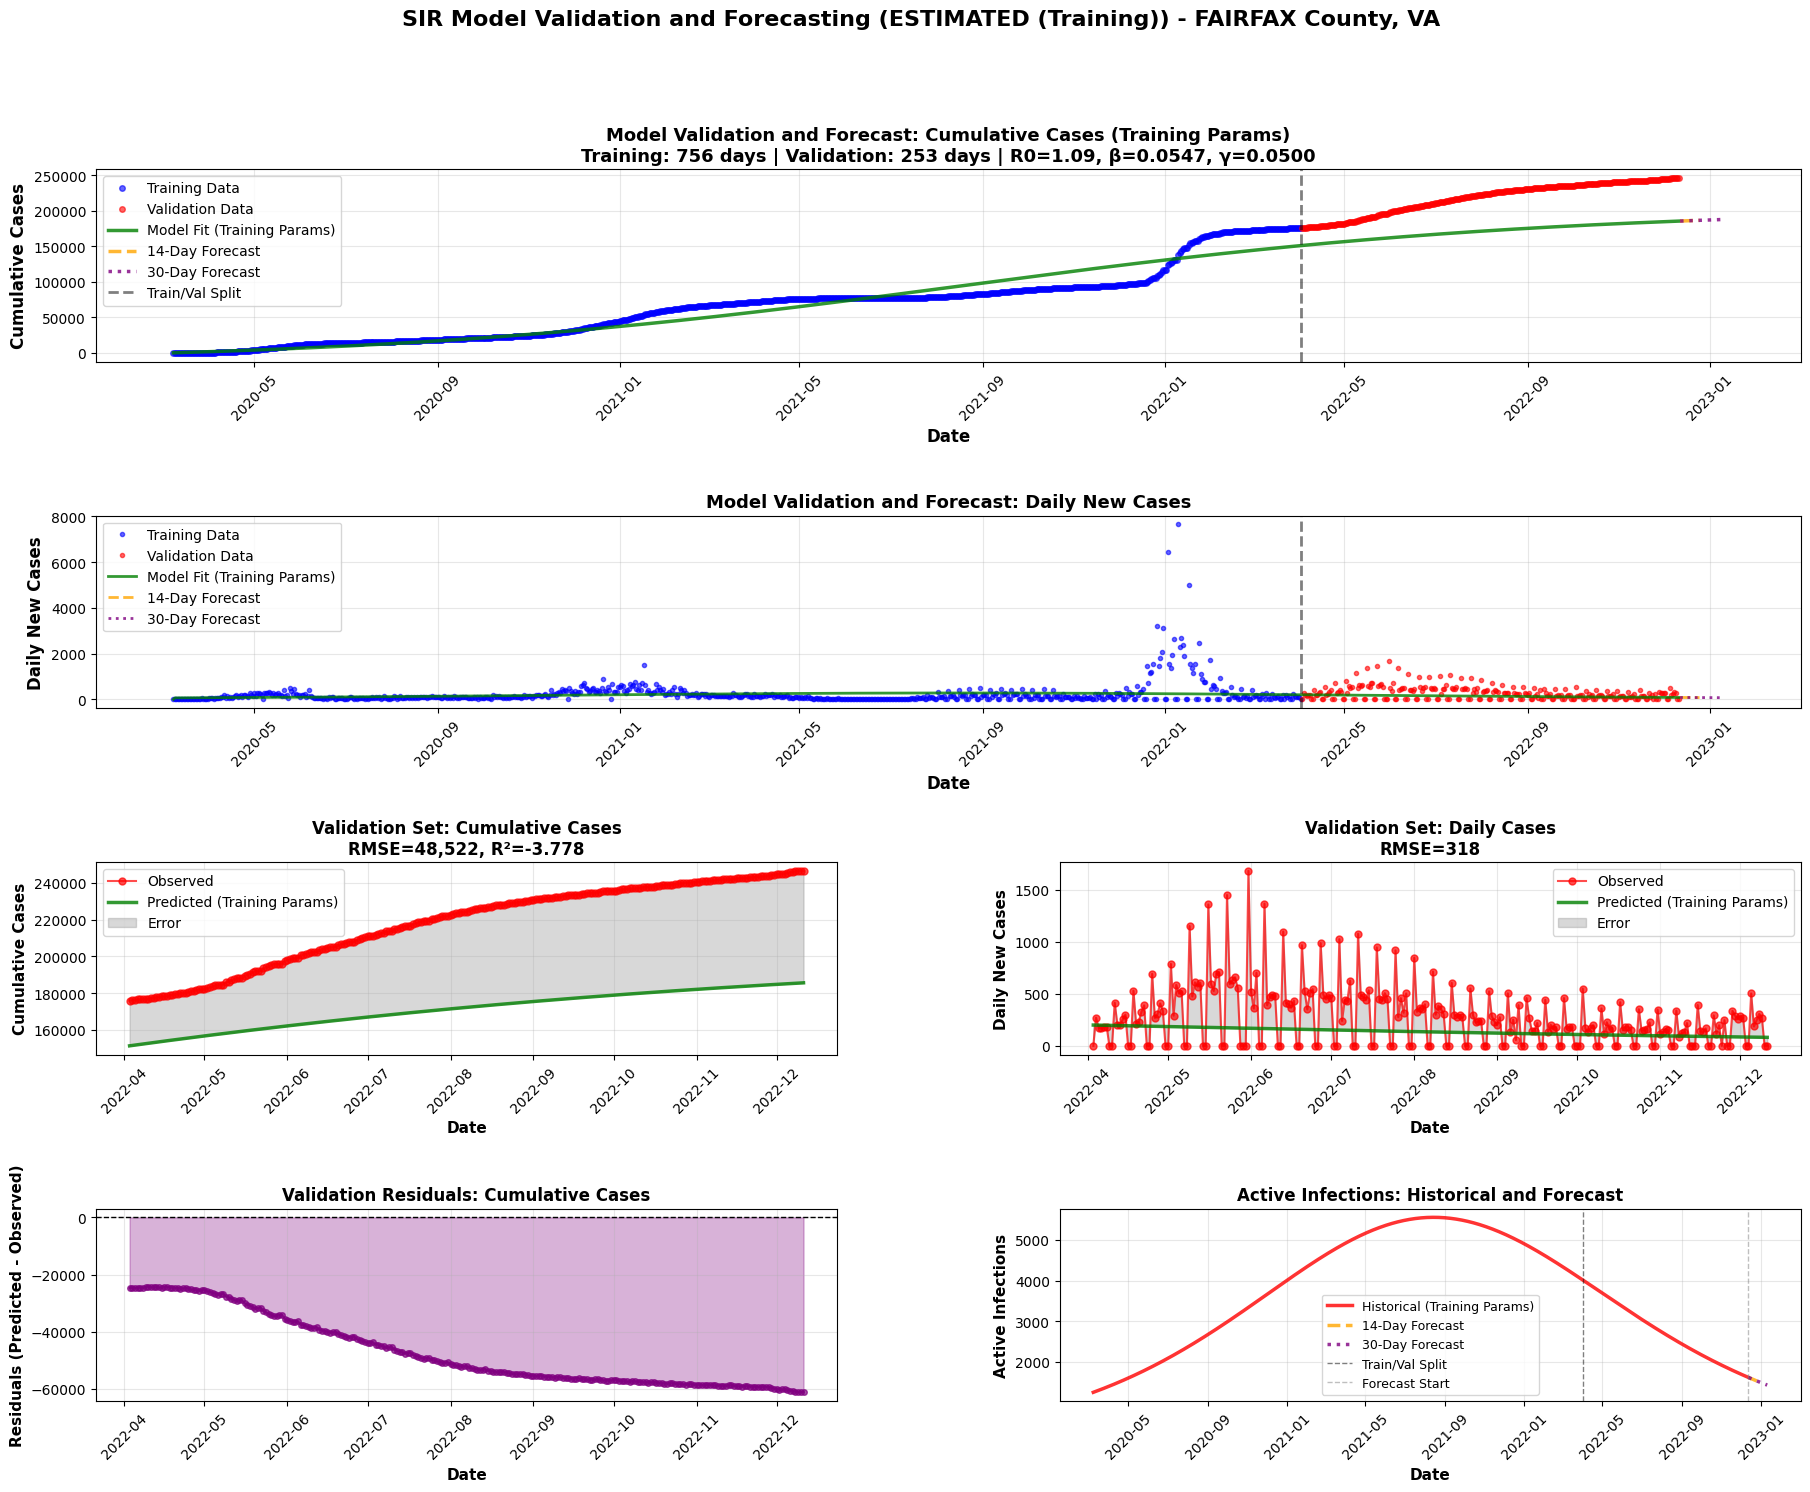


Plot saved: material/plots/2_model_validation_and_forecast.png

Note: All plots use parameters estimated from TRAINING data only:
  β = 0.054727, γ = 0.050000, R0 = 1.0945


In [12]:
print("\n" + "=" * 70)
print("CREATING VALIDATION AND FORECAST PLOTS")
print("=" * 70)

dates_all = county_data['date'].values
dates_train = dates_all[:n_train]
dates_val = dates_all[n_train:]

fig = plt.figure(figsize=(22, 16))
gs = fig.add_gridspec(4, 2, hspace=0.8, wspace=0.3)

# Plot 1: Cumulative Cases - Train, Validation, and Forecast
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates_train, cumulative_cases_train, 'o', color='blue', 
         label='Training Data', alpha=0.6, markersize=4)
ax1.plot(dates_val, cumulative_cases_validation, 'o', color='red', 
         label='Validation Data', alpha=0.6, markersize=4)
ax1.plot(dates_all, R_pred, '-', color='green', 
         label='Model Fit (Training Params)', linewidth=2.5, alpha=0.8)
ax1.plot(forecast_dates_14, R_forecast_14_vals, '--', color='orange', 
         label=f'{FORECAST_DAYS_14}-Day Forecast', linewidth=2.5, alpha=0.8)
ax1.plot(forecast_dates_30, R_forecast_30_vals, ':', color='purple', 
         label=f'{FORECAST_DAYS_30}-Day Forecast', linewidth=2.5, alpha=0.8)
ax1.axvline(x=dates_train[-1], color='black', linestyle='--', linewidth=2, alpha=0.5, 
            label='Train/Val Split')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Cases', fontsize=12, fontweight='bold')
ax1.set_title(f'Model Validation and Forecast: Cumulative Cases (Training Params)\n' +
              f'Training: {n_train} days | Validation: {n_validation} days | ' +
              f'R0={R0_train:.2f}, β={beta_train:.4f}, γ={gamma_train:.4f}',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Daily Cases - Train, Validation, and Forecast
ax2 = fig.add_subplot(gs[1, :])
daily_cases_all = county_data['daily_cases'].values

ax2.plot(dates_train, daily_cases_all[:n_train], 'o', color='blue', 
         label='Training Data', alpha=0.6, markersize=3)
ax2.plot(dates_val, daily_cases_all[n_train:], 'o', color='red', 
         label='Validation Data', alpha=0.6, markersize=3)
ax2.plot(dates_all, daily_cases_pred, '-', color='green', 
         label='Model Fit (Training Params)', linewidth=2, alpha=0.8)
ax2.plot(forecast_dates_14, daily_forecast_14, '--', color='orange', 
         label=f'{FORECAST_DAYS_14}-Day Forecast', linewidth=2, alpha=0.8)
ax2.plot(forecast_dates_30, daily_forecast_30, ':', color='purple', 
         label=f'{FORECAST_DAYS_30}-Day Forecast', linewidth=2, alpha=0.8)
ax2.axvline(x=dates_train[-1], color='black', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Daily New Cases', fontsize=12, fontweight='bold')
ax2.set_title('Model Validation and Forecast: Daily New Cases',
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Validation Set - Cumulative Cases Detail
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(dates_val, cumulative_cases_validation, 'ro-', 
         label='Observed', alpha=0.7, markersize=5)
ax3.plot(dates_val, R_pred_val, 'g-', 
         label='Predicted (Training Params)', linewidth=2.5, alpha=0.8)
ax3.fill_between(dates_val, cumulative_cases_validation, R_pred_val, 
                 alpha=0.3, color='gray', label='Error')
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Cases', fontsize=11, fontweight='bold')
ax3.set_title(f'Validation Set: Cumulative Cases\n' +
              f'RMSE={rmse_val_cum:,.0f}, R²={r2_val_cum:.3f}',
              fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Validation Set - Daily Cases Detail
ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(dates_val, daily_cases_validation, 'ro-', 
         label='Observed', alpha=0.7, markersize=5)
ax4.plot(dates_val, daily_cases_pred_val, 'g-', 
         label='Predicted (Training Params)', linewidth=2.5, alpha=0.8)
ax4.fill_between(dates_val, daily_cases_validation, daily_cases_pred_val, 
                 alpha=0.3, color='gray', label='Error')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_ylabel('Daily New Cases', fontsize=11, fontweight='bold')
ax4.set_title(f'Validation Set: Daily Cases\n' +
              f'RMSE={rmse_val_daily:,.0f}',
              fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Residuals on Validation Set
ax5 = fig.add_subplot(gs[3, 0])
ax5.plot(dates_val, residuals_val_cum, 'o-', color='purple', alpha=0.7, markersize=4)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.fill_between(dates_val, residuals_val_cum, 0, alpha=0.3, color='purple')
ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
ax5.set_ylabel('Residuals (Predicted - Observed)', fontsize=11, fontweight='bold')
ax5.set_title('Validation Residuals: Cumulative Cases',
              fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Active Infections - Forecast
ax6 = fig.add_subplot(gs[3, 1])
ax6.plot(dates_all, I_pred, '-', color='red', 
         label='Historical (Training Params)', linewidth=2.5, alpha=0.8)
ax6.plot(forecast_dates_14, I_forecast_14_vals, '--', color='orange', 
         label=f'{FORECAST_DAYS_14}-Day Forecast', linewidth=2.5, alpha=0.8)
ax6.plot(forecast_dates_30, I_forecast_30_vals, ':', color='purple', 
         label=f'{FORECAST_DAYS_30}-Day Forecast', linewidth=2.5, alpha=0.8)
ax6.axvline(x=dates_train[-1], color='black', linestyle='--', linewidth=1, alpha=0.5, 
            label='Train/Val Split')
ax6.axvline(x=dates_all[-1], color='gray', linestyle='--', linewidth=1, alpha=0.5, 
            label='Forecast Start')
ax6.set_xlabel('Date', fontsize=11, fontweight='bold')
ax6.set_ylabel('Active Infections', fontsize=11, fontweight='bold')
ax6.set_title('Active Infections: Historical and Forecast',
              fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

param_source_display = 'ESTIMATED (Training)' if USE_ESTIMATED_PARAMETERS else 'WHO' if USE_WHO_PARAMETERS else 'CUSTOM'
plt.suptitle(f'SIR Model Validation and Forecasting ({param_source_display}) - FAIRFAX County, VA', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('material/plots/2_model_validation_and_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved: material/plots/2_model_validation_and_forecast.png")
print(f"\nNote: All plots use parameters estimated from TRAINING data only:")
print(f"  β = {beta_train:.6f}, γ = {gamma_train:.6f}, R0 = {R0_train:.4f}")

In [13]:
print("\n" + "=" * 70)
print("FORECAST PLAUSIBILITY ANALYSIS")
print("=" * 70)

# Calculate daily growth rates
daily_cases_all = county_data['daily_cases'].values
daily_growth_observed = daily_cases_all[-7:].mean()
daily_growth_forecast_14 = daily_forecast_14.mean()
daily_growth_forecast_30 = daily_forecast_30.mean()

print(f"\nDaily Case Growth Analysis:")
print(f"  Recent observed (last 7 days avg): {daily_growth_observed:.1f} cases/day")
print(f"  {FORECAST_DAYS_14}-day forecast average: {daily_growth_forecast_14:.1f} cases/day")
print(f"  {FORECAST_DAYS_30}-day forecast average: {daily_growth_forecast_30:.1f} cases/day")

# Calculate percentage changes
pct_change_cum_14 = ((R_forecast_14_vals[-1] - R_pred[-1]) / R_pred[-1]) * 100
pct_change_cum_30 = ((R_forecast_30_vals[-1] - R_pred[-1]) / R_pred[-1]) * 100

print(f"\nCumulative Case Increase:")
print(f"  Current total: {int(R_pred[-1]):,} cases")
print(f"  {FORECAST_DAYS_14}-day forecast: {int(R_forecast_14_vals[-1]):,} cases (+{pct_change_cum_14:.1f}%)")
print(f"  {FORECAST_DAYS_30}-day forecast: {int(R_forecast_30_vals[-1]):,} cases (+{pct_change_cum_30:.1f}%)")

# Attack rate projection
attack_rate_current = (R_pred[-1] / COUNTY_POPULATION) * 100
attack_rate_14 = (R_forecast_14_vals[-1] / COUNTY_POPULATION) * 100
attack_rate_30 = (R_forecast_30_vals[-1] / COUNTY_POPULATION) * 100

print(f"\nAttack Rate (% of population infected):")
print(f"  Current: {attack_rate_current:.2f}%")
print(f"  {FORECAST_DAYS_14}-day forecast: {attack_rate_14:.2f}%")
print(f"  {FORECAST_DAYS_30}-day forecast: {attack_rate_30:.2f}%")

# Epidemic status (using TRAINING parameters)
current_R_eff = beta_train * (S_pred[-1] / COUNTY_POPULATION) / gamma_train
forecast_R_eff_14 = beta_train * (S_forecast_14_vals[-1] / COUNTY_POPULATION) / gamma_train
forecast_R_eff_30 = beta_train * (S_forecast_30_vals[-1] / COUNTY_POPULATION) / gamma_train

print(f"\nEffective Reproduction Number (R_eff = R0 × S/N):")
print(f"  Current: {current_R_eff:.3f}")
print(f"  {FORECAST_DAYS_14}-day forecast: {forecast_R_eff_14:.3f}")
print(f"  {FORECAST_DAYS_30}-day forecast: {forecast_R_eff_30:.3f}")

print(f"\nEpidemic Status:")
if current_R_eff > 1:
    print(f"  ⚠ Currently GROWING (R_eff={current_R_eff:.2f} > 1)")
else:
    print(f"  ✓ Currently DECLINING (R_eff={current_R_eff:.2f} < 1)")

if forecast_R_eff_30 > 1:
    print(f"  ⚠ Will continue GROWING in {FORECAST_DAYS_30} days (R_eff={forecast_R_eff_30:.2f} > 1)")
else:
    print(f"  ✓ Will be DECLINING in {FORECAST_DAYS_30} days (R_eff={forecast_R_eff_30:.2f} < 1)")

print("\n" + "=" * 70)
print("PLAUSIBILITY DISCUSSION")
print("=" * 70)

param_source_forecast = 'ESTIMATED (Training)' if USE_ESTIMATED_PARAMETERS else 'WHO' if USE_WHO_PARAMETERS else 'CUSTOM'

print(f"""
The forecast plausibility can be assessed based on several factors:

1. PARAMETER SOURCE FOR FORECAST: {param_source_forecast}
   - Parameters estimated from TRAINING data only ({n_train} days, {TRAIN_RATIO*100:.0f}% of data)
   - Validation set ({n_validation} days) was NOT used in parameter estimation
   - This ensures forecasts are truly out-of-sample predictions
   {"- Parameters: β=" + f"{beta_train:.4f}, γ={gamma_train:.4f}, R0={R0_train:.2f}" }
   - The SIR model assumes constant β and γ throughout the forecast period
   - No interventions (lockdowns, vaccines, behavioral changes) are modeled

2. VALIDATION PERFORMANCE:
   - Validation R² = {r2_val_cum:.3f} (closer to 1.0 is better)
   - RMSE ratio (Val/Train) = {rmse_val_cum/rmse_train_cum:.2f}
   - {'Good generalization' if rmse_val_cum/rmse_train_cum < 1.5 else 'Moderate/Poor generalization'}
   - {'Model generalizes well to unseen data' if rmse_val_cum/rmse_train_cum < 1.5 else 'Model may not generalize well'}

3. FORECAST TRENDS:
   - R_eff = {current_R_eff:.2f} indicates epidemic is {'growing' if current_R_eff > 1 else 'declining'}
   - Daily case trend: {daily_growth_forecast_30:.1f} cases/day ({FORECAST_DAYS_30}-day avg)
   - Attack rate projection: {attack_rate_30:.1f}% of population by end of forecast

4. LIMITATIONS:
   - SIR is a simple deterministic model that may not capture:
     * Stochastic variations in transmission
     * Heterogeneity in population mixing
     * Age structure and vulnerability differences
     * Policy interventions and behavioral changes
     * Imported cases and spatial dynamics
     * Parameter drift over time
   
5. CONFIDENCE:
   - Short-term ({FORECAST_DAYS_14} days): {'MODERATE to HIGH' if r2_val_cum > 0.7 else 'LOW to MODERATE'} confidence
     * Less time for parameter drift
     * Fewer compounding errors
     * Validation R² = {r2_val_cum:.3f}
   
   - Long-term ({FORECAST_DAYS_30} days): {'MODERATE' if r2_val_cum > 0.8 else 'LOW to MODERATE'} confidence
     * More uncertainty accumulates
     * Higher chance of external changes
     * Model assumptions more likely to be violated

6. OUT-OF-SAMPLE VALIDATION:
   - ✓ Parameters estimated ONLY from training data
   - ✓ Validation set never used in parameter estimation
   - ✓ Forecast represents true predictive performance
   - {'✓ Validation RMSE/Training RMSE < 1.5 indicates good generalization' if rmse_val_cum/rmse_train_cum < 1.5 else '⚠ Validation RMSE/Training RMSE ≥ 1.5 suggests limited generalization'}

RECOMMENDATION:
The forecasts should be treated as scenario projections rather than precise
predictions. They are most useful for understanding potential trajectories
IF conditions remain similar to the training period. The validation results
suggest {'the model has reasonable predictive power' if r2_val_cum > 0.7 else 'the model has limited predictive power'}.
Real-world interventions, behavioral changes, or other factors not captured
by the model will cause actual outcomes to deviate from these projections.
""")

print("\n" + "=" * 70)
print("MODEL VALIDATION AND FORECASTING COMPLETE")
print("=" * 70)


FORECAST PLAUSIBILITY ANALYSIS

Daily Case Growth Analysis:
  Recent observed (last 7 days avg): 216.4 cases/day
  14-day forecast average: 79.1 cases/day
  30-day forecast average: 76.5 cases/day

Cumulative Case Increase:
  Current total: 185,654 cases
  14-day forecast: 186,762 cases (+0.6%)
  30-day forecast: 187,949 cases (+1.2%)

Attack Rate (% of population infected):
  Current: 16.18%
  14-day forecast: 16.28%
  30-day forecast: 16.38%

Effective Reproduction Number (R_eff = R0 × S/N):
  Current: 0.916
  14-day forecast: 0.915
  30-day forecast: 0.914

Epidemic Status:
  ✓ Currently DECLINING (R_eff=0.92 < 1)
  ✓ Will be DECLINING in 30 days (R_eff=0.91 < 1)

PLAUSIBILITY DISCUSSION

The forecast plausibility can be assessed based on several factors:

1. PARAMETER SOURCE FOR FORECAST: ESTIMATED (Training)
   - Parameters estimated from TRAINING data only (756 days, 75% of data)
   - Validation set (253 days) was NOT used in parameter estimation
   - This ensures forecasts are 

In [14]:
print("\n" + "=" * 70)
print("FINAL SUMMARY REPORT")
print("=" * 70)

print(f"\n{'='*70}")
print(f"FAIRFAX COUNTY, VIRGINIA - COVID-19 SIR MODEL ANALYSIS")
print(f"{'='*70}")

print(f"\n1. DATA OVERVIEW")
print(f"   Population: {COUNTY_POPULATION:,}")
print(f"   Observation Period: {pd.Timestamp(county_data['date'].iloc[0]).strftime('%Y-%m-%d')} to {pd.Timestamp(county_data['date'].iloc[-1]).strftime('%Y-%m-%d')}")
print(f"   Total Days: {n_total}")
print(f"   Total Cases: {county_data['cumulative_cases'].iloc[-1]:,.0f}")
print(f"   Total Deaths: {county_data['cumulative_deaths'].iloc[-1]:,.0f}")

print(f"\n2. MODEL PARAMETERS (Source: {PARAM_SOURCE})")
print(f"   β (Transmission rate):     {BETA_GLOBAL:.6f} per day")
print(f"   γ (Recovery rate):         {GAMMA_GLOBAL:.6f} per day")
print(f"   R0 (Basic reproduction):   {R0_GLOBAL:.4f}")
print(f"   Infectious period (1/γ):   {INFECTIOUS_PERIOD_GLOBAL:.2f} days")
print(f"   Initial infected (I0):     {int(I0_GLOBAL)} persons")

print(f"\n3. MODEL FIT (Full Dataset)")
print(f"   Cumulative Cases:")
print(f"      RMSE: {rmse_cum:,.2f} cases")
print(f"      MAE:  {mae_cum:,.2f} cases")
print(f"      R²:   {r_squared_cum:.4f}")
print(f"   Daily Cases:")
print(f"      RMSE: {rmse_daily:,.2f} cases/day")
print(f"      MAE:  {mae_daily:,.2f} cases/day")

print(f"\n4. VALIDATION RESULTS")
print(f"   Training Set: {n_train} days ({TRAIN_RATIO*100:.0f}%)")
print(f"      RMSE: {rmse_train_cum:,.2f} cases")
print(f"      R²:   {r2_train_cum:.4f}")
print(f"   Validation Set: {n_validation} days ({(1-TRAIN_RATIO)*100:.0f}%)")
print(f"      RMSE: {rmse_val_cum:,.2f} cases")
print(f"      R²:   {r2_val_cum:.4f}")
print(f"   Generalization Ratio: {rmse_val_cum/rmse_train_cum:.2f}")
print(f"   {'✓ Good generalization' if rmse_val_cum/rmse_train_cum < 1.5 else '⚠ Moderate/Poor generalization'}")

print(f"\n5. FORECASTS")
print(f"   {FORECAST_DAYS_14}-Day Forecast:")
print(f"      Predicted Cases: {int(R_forecast_14_vals[-1]):,} (+{pct_change_cum_14:.1f}%)")
print(f"      Active Infections: {int(I_forecast_14_vals[-1]):,}")
print(f"      Attack Rate: {attack_rate_14:.2f}%")
print(f"      R_eff: {forecast_R_eff_14:.3f}")
print(f"   {FORECAST_DAYS_30}-Day Forecast:")
print(f"      Predicted Cases: {int(R_forecast_30_vals[-1]):,} (+{pct_change_cum_30:.1f}%)")
print(f"      Active Infections: {int(I_forecast_30_vals[-1]):,}")
print(f"      Attack Rate: {attack_rate_30:.2f}%")
print(f"      R_eff: {forecast_R_eff_30:.3f}")

print(f"\n6. EPIDEMIC STATUS")
print(f"   Current R_eff: {current_R_eff:.3f}")
if current_R_eff > 1:
    print(f"   ⚠ Epidemic is GROWING (R_eff > 1)")
else:
    print(f"   ✓ Epidemic is DECLINING (R_eff < 1)")

print(f"\n7. FILES GENERATED")
print(f"   - material/plots/0_sir_scenarios.png (if run)")
print(f"   - material/plots/1_parameter_estimation.png")
print(f"   - material/plots/2_model_validation_and_forecast.png")

print(f"\n{'='*70}")
print(f"ANALYSIS COMPLETE")
print(f"{'='*70}")

print(f"\nTo modify analysis:")
print(f"  - Change CELDA 2: Configuration settings")
print(f"    * USE_ESTIMATED_PARAMETERS: True/False")
print(f"    * USE_WHO_PARAMETERS: True/False")
print(f"    * CUSTOM parameters if both above are False")
print(f"    * TRAIN_RATIO, FORECAST_DAYS, etc.")
print(f"  - Re-run all subsequent cells")
print(f"\nGlobal Variables Available for Further Analysis:")
print(f"  - BETA_GLOBAL, GAMMA_GLOBAL, I0_GLOBAL")
print(f"  - R0_GLOBAL, INFECTIOUS_PERIOD_GLOBAL")
print(f"  - COUNTY_POPULATION")
print(f"  - county_data (DataFrame with all results)")


FINAL SUMMARY REPORT

FAIRFAX COUNTY, VIRGINIA - COVID-19 SIR MODEL ANALYSIS

1. DATA OVERVIEW
   Population: 1,147,532
   Observation Period: 2020-03-08 to 2022-12-11
   Total Days: 1009
   Total Cases: 246,667
   Total Deaths: 1,710

2. MODEL PARAMETERS (Source: ESTIMATED)
   β (Transmission rate):     0.056434 per day
   γ (Recovery rate):         0.050000 per day
   R0 (Basic reproduction):   1.1287
   Infectious period (1/γ):   20.00 days
   Initial infected (I0):     585 persons

3. MODEL FIT (Full Dataset)
   Cumulative Cases:
      RMSE: 16,045.74 cases
      MAE:  12,733.53 cases
      R²:   0.9593
   Daily Cases:
      RMSE: 478.56 cases/day
      MAE:  234.29 cases/day

4. VALIDATION RESULTS
   Training Set: 756 days (75%)
      RMSE: 14,409.48 cases
      R²:   0.9121
   Validation Set: 253 days (25%)
      RMSE: 48,522.03 cases
      R²:   -3.7784
   Generalization Ratio: 3.37
   ⚠ Moderate/Poor generalization

5. FORECASTS
   14-Day Forecast:
      Predicted Cases: 186,7